# **Assignment 5 - Task 3: Universal Sparse Autoencoders**

## **TASK 3.1: USAE TRAINING & SETUP**
This part covers the setup, activation extraction, and training of a Universal Sparse Autoencoder (USAE) to align features between a ResNet-18 and a ViT-B/16.

In [1]:
# # Clear GPU memory
# import gc
# import torch

# # torch.cuda.empty_cache()
# gc.collect()

# # Check available memory
# print(f"GPU Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
# print(f"GPU Memory reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
# print(f"GPU Memory free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

In [2]:
# import shutil
# disk = shutil.disk_usage('./')
# print(f"Total: {disk.total / 1e9:.2f} GB")
# print(f"Used: {disk.used / 1e9:.2f} GB")
# print(f"Free: {disk.free / 1e9:.2f} GB")

---

### **SECTION 1: Setup & Installation**

In [3]:
import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import r2_score as sklearn_r2
from torch.utils.data import DataLoader

os.environ["TQDM_NOTEBOOK"] = "0"
os.environ["WANDB_MODE"] = "disabled"
from tqdm import tqdm

# Overcomplete/USAE imports
sys.path.append("./UniversalSAE")  # Add UniversalSAE to Python path
from overcomplete.sae import TopKSAE
from overcomplete.sae.losses import top_k_auxiliary_loss
from overcomplete.sae.optimizer import CosineScheduler
from overcomplete.sae.topk_sae import TopKSAE
from universal_sae.train import train_cross_prediction_saes

# Verify GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

GPU Available: True
GPU Name: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
GPU Memory: 101.97 GB


In [4]:
# # Delete any old cached files
# import shutil
# if os.path.exists('./cached_activations'):
#     shutil.rmtree('./cached_activations')
# os.makedirs('./cached_activations')

---

### **SECTION 2: Model Selection & Activation Extraction**

We will use two distinct architectures trained on CIFAR concepts:
1. **ResNet-18** (CNN)
2. **ViT-B/16** (Transformer)

In [5]:
# Choose 2 models with different architectures
# ResNet-18: CNN-based
model_resnet = torchvision.models.resnet18(pretrained=True).cuda().eval()

# ViT-B/16: Transformer-based
model_vit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True).cuda().eval()

# Remove classification heads to get features where possible, or just ignore output
model_resnet = nn.Sequential(*list(model_resnet.children())[:-1])  # Remove avgpool + fc
model_vit.head = nn.Identity()  # Remove classification head

/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/venv/main/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/venv/main/lib/python3.12/site-packag

In [6]:
def extract_activation_layer(model, model_type):
    """Get the layer to extract activations from"""
    if model_type == 'resnet':
        # Extract from layer4 (before global avg pool)
        return model[-2]  # layer4
    elif model_type == 'vit':
        # Extract from last transformer block
        return model.blocks[-1]
    
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
resnet_hook = model_resnet[-2].register_forward_hook(get_activation('resnet'))
vit_hook = model_vit.blocks[-1].register_forward_hook(get_activation('vit'))

# Aliases for Task 3.4 compatibility
resnet_model = model_resnet
vit_model = model_vit

# Extraction helper functions for Task 3.4
def extract_resnet_features(images, model):
    """Extract ResNet layer4 activations: [B, 196, 512]"""
    _ = model(images)
    resnet_act = activations['resnet']  # [B, 512, 7, 7]
    resnet_act = torch.nn.functional.interpolate(
        resnet_act, size=(14, 14), mode='bilinear', align_corners=False
    )
    return resnet_act.flatten(2).permute(0, 2, 1)  # [B, 196, 512]

def extract_vit_features(images, model):
    """Extract ViT last block activations: [B, 196, 768]"""
    _ = model(images)
    vit_act = activations['vit'][:, 1:, :]  # Remove CLS token
    return vit_act

In [7]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full CIFAR-100 train set (50k images)
cifar100_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

# Create dataloader
cifar_loader = DataLoader(cifar100_train, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [8]:
cache_path = './cached_activations/cifar100_activations.pt'

if not os.path.exists(cache_path):
    print("Extracting activations from ResNet and ViT...")
    
    resnet_acts = []
    vit_acts = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(cifar_loader, desc="Extracting activations"):
            images = images.cuda()
            
            # Forward pass through both models
            _ = model_resnet(images)
            _ = model_vit(images)
            
            # Get activations
            # ResNet: (batch, 512, 7, 7) -> interpolate to 14x14 -> (batch, 196, 512)
            resnet_act = activations['resnet']  # (batch, 512, 7, 7)
            resnet_act = torch.nn.functional.interpolate(
                resnet_act, size=(14, 14), mode='bilinear', align_corners=False
            )
            resnet_act = resnet_act.flatten(2).permute(0, 2, 1)  # (batch, 196, 512)
            resnet_acts.append(resnet_act.cpu())
            
            # ViT: (batch, 197, 768) -> remove CLS -> (batch, 196, 768)
            vit_act = activations['vit'][:, 1:, :]  # Remove CLS token
            vit_acts.append(vit_act.cpu())
            
            # Labels (one per image)
            labels_list.append(labels)

    # Concatenate all batches
    resnet_activations = torch.cat(resnet_acts, dim=0)  # (50000, 196, 512)
    vit_activations = torch.cat(vit_acts, dim=0)        # (50000, 196, 768)
    all_labels = torch.cat(labels_list, dim=0)

    print(f"ResNet activations shape: {resnet_activations.shape}")
    print(f"ViT activations shape: {vit_activations.shape}")

    # Save
    os.makedirs('./cached_activations', exist_ok=True)
    torch.save({
        'resnet': resnet_activations,
        'vit': vit_activations,
        'labels': all_labels
    }, './cached_activations/cifar100_activations.pt')

    print("✓ Activations cached successfully!")
    
else:
    print(f"✓ Activations already cached at {cache_path}, skipping extraction")

✓ Activations already cached at ./cached_activations/cifar100_activations.pt, skipping extraction


---

### **SECTION 3: Dataset Preparation**

In [9]:
class MultiModelActivationDataset(torch.utils.data.Dataset):
    def __init__(self, activations_dict, labels):
        """
        activations_dict: {'model_name': tensor of activations}
        labels: labels for each sample
        """
        self.activations = activations_dict
        self.labels = labels
        # We truncate to the length of the smallest dataset to ensure alignment if training requires parallel batches,
        # or just use independent sampling. For this implementation, we assume we want equal batch sizes.
        self.length = min(len(acts) for acts in activations_dict.values())
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # Return dict of activations for each model
        batch = {name: acts[idx] for name, acts in self.activations.items()}
        return batch, self.labels[idx]

# Load cached activations
cached = torch.load('./cached_activations/cifar100_activations.pt')

# Create dataset
activation_dataset = MultiModelActivationDataset(
    activations_dict={
        'ResNet': cached['resnet'],
        'ViT': cached['vit']
    },
    labels=cached['labels']
)

print(f"Dataset size: {len(activation_dataset)} samples")

Dataset size: 50000 samples


In [10]:
# Compute mean/std for each model (for normalization)
model_stats = {}

for model_name, cache_key in [('ResNet', 'resnet'), ('ViT', 'vit')]:
    acts = cached[cache_key]
    model_stats[model_name] = {
        'mean': acts.mean().item(),
        'std': acts.std().item(),
        'input_shape': acts.shape[2]  # 512 for ResNet, 768 for ViT
    }
    print(f"{model_name} - Mean: {model_stats[model_name]['mean']:.4f}, Std: {model_stats[model_name]['std']:.4f}")

ResNet - Mean: 0.7213, Std: 1.3053
ViT - Mean: -0.0203, Std: 4.2417


---

### **SECTION 4: USAE Architecture & Training Config**

In [11]:
CONFIG = {
    # Data
    'batch_size': 64,
    
    # Model architecture
    'nb_components': 16384,
    'top_k': 32,
    
    # Training
    'nb_epochs': 80,
    'lr': 3e-4,
    'final_lr': 1e-6,
    'weight_decay': 1e-5,
    'warmup_epochs': 2.0,
    
    # Other
    'standardize': True,
    'debug': 1,  # Logging level
    'run_name': 'USAE_ResNet_ViT_CIFAR100_16k_80ep'
}

SAE_PARAMS = {
    'encoder_module': 'mlp_bn_1',
    'dictionary_initializer': None,
    'data_initializer': None,
    'dictionary_normalization': 'l2',
    'top_k': CONFIG['top_k']
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"    {k}: {v}")


Configuration:
    batch_size: 64
    nb_components: 16384
    top_k: 32
    nb_epochs: 80
    lr: 0.0003
    final_lr: 1e-06
    weight_decay: 1e-05
    warmup_epochs: 2.0
    standardize: True
    debug: 1
    run_name: USAE_ResNet_ViT_CIFAR100_16k_80ep


In [12]:
model_zoo = {
    'ResNet': {
        'input_shape': 512,
        'num_tokens': 196,
        'model_mean': model_stats['ResNet']['mean'],
        'model_std': model_stats['ResNet']['std'],
    },
    'ViT': {
        'input_shape': 768,
        'num_tokens': 196,
        'model_mean': model_stats['ViT']['mean'],
        'model_std': model_stats['ViT']['std'],
    }
}

print("\nModel Zoo:")
for name, config in model_zoo.items():
    print(f"  {name}: input_shape={config['input_shape']}, mean={config['model_mean']:.4f}")


Model Zoo:
  ResNet: input_shape=512, mean=0.7213
  ViT: input_shape=768, mean=-0.0203


---

### **SECTION 5: USAE Training**

In [13]:
# Create dataloader
dataloader = DataLoader(
    activation_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    pin_memory=True, 
    num_workers=8
)

# Calculate training iterations
total_iters = len(activation_dataset) // CONFIG['batch_size'] * CONFIG['nb_epochs']
warmup_iters = int(len(activation_dataset) // CONFIG['batch_size'] * CONFIG['warmup_epochs'])

print(f"Total iterations: {total_iters}")
print(f"Warmup iterations: {warmup_iters}")

# Initialize SAEs (one per model)
saes = {}
optimizers = {}
schedulers = {}

for model_name in model_zoo:
    print(f"\nInitializing SAE for {model_name}...")
    
    saes[model_name] = TopKSAE(
        input_shape=model_zoo[model_name]['input_shape'],
        n_components=CONFIG['nb_components'],
        device='cuda',
        **SAE_PARAMS
    )
    
    optimizers[model_name] = optim.AdamW(
        saes[model_name].parameters(),
        lr=CONFIG['lr'],
        weight_decay=CONFIG['weight_decay']
    )
    
    schedulers[model_name] = CosineScheduler(
        optimizers[model_name],
        CONFIG['lr'],
        CONFIG['final_lr'],
        total_iters=total_iters,
        warmup_iters=warmup_iters,
        start_warmup_value=1e-6
    )
    
    print(f"  ✓ SAE created with {CONFIG['nb_components']} components")

Total iterations: 62480
Warmup iterations: 1562

Initializing SAE for ResNet...
-----HERE-----
  ✓ SAE created with 16384 components

Initializing SAE for ViT...
-----HERE-----
  ✓ SAE created with 16384 components


In [14]:
# Find latest checkpoint for each model
checkpoint_files = {}
for model_name in model_zoo.keys():
    # First check checkpoints folder
    checkpoint_path = f'./checkpoints/usae_{model_name}_final.pth'
    if os.path.exists(checkpoint_path):
        checkpoint_files[model_name] = checkpoint_path
    else:
        # Fallback to weights folder
        files = glob.glob(f'./weights/USAE_ResNet_ViT_CIFAR100_16k_80ep/{model_name}/uni_{model_name}_checkpoint_*.pth')
        if files:
            # Get the one with highest epoch number
            latest = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
            checkpoint_files[model_name] = latest

if len(checkpoint_files) == len(model_zoo):
    print("✓ Found existing checkpoints! Loading trained models...")
    for model_name, path in checkpoint_files.items():
        checkpoint = torch.load(path)
        saes[model_name].load_state_dict(checkpoint['model_state_dict'])
        saes[model_name].eval()
        print(f"  ✓ Loaded {model_name} from {path}")
        if 'epoch' in checkpoint:
            print(f"      (epoch {checkpoint['epoch']})")
else:
    print("No checkpoints found. Starting training...")
    # Use the repo's training function
    logs = train_cross_prediction_saes(
        saes=saes,
        dataloader=dataloader,
        criterion=top_k_auxiliary_loss,
        sae_optimizers=optimizers,
        sae_schedulers=schedulers,
        nb_epochs=CONFIG['nb_epochs'],
        clip_grad=1.0,
        monitoring=CONFIG['debug'],
        device='cuda',
        model_name=CONFIG['run_name'],
        model_zoo=model_zoo,
        divide_norm=False,
        seeded=True
    )
    print("\n✓ Training complete!")

✓ Found existing checkpoints! Loading trained models...
  ✓ Loaded ResNet from ./checkpoints/usae_ResNet_final.pth
  ✓ Loaded ViT from ./checkpoints/usae_ViT_final.pth


---

### **SECTION 6: Save Checkpoints**

In [15]:
os.makedirs('./checkpoints', exist_ok=True)

for model_name, sae in saes.items():
    checkpoint_path = f'./checkpoints/usae_{model_name}_final.pth'
    torch.save({
        'model_state_dict': sae.state_dict(),
        'config': CONFIG,
        'model_config': model_zoo[model_name]
    }, checkpoint_path)
    print(f"✓ Saved {model_name} SAE to {checkpoint_path}")

# Save logs only if they exist (i.e., if we trained)
if 'logs' in locals():
    torch.save(logs, './checkpoints/training_logs.pt')
    print("✓ Saved training logs")
else:
    print("✓ Loaded from existing checkpoints, no new logs to save")

✓ Saved ResNet SAE to ./checkpoints/usae_ResNet_final.pth
✓ Saved ViT SAE to ./checkpoints/usae_ViT_final.pth
✓ Loaded from existing checkpoints, no new logs to save


---

### **SECTION 7: Evaluation & Visualization**

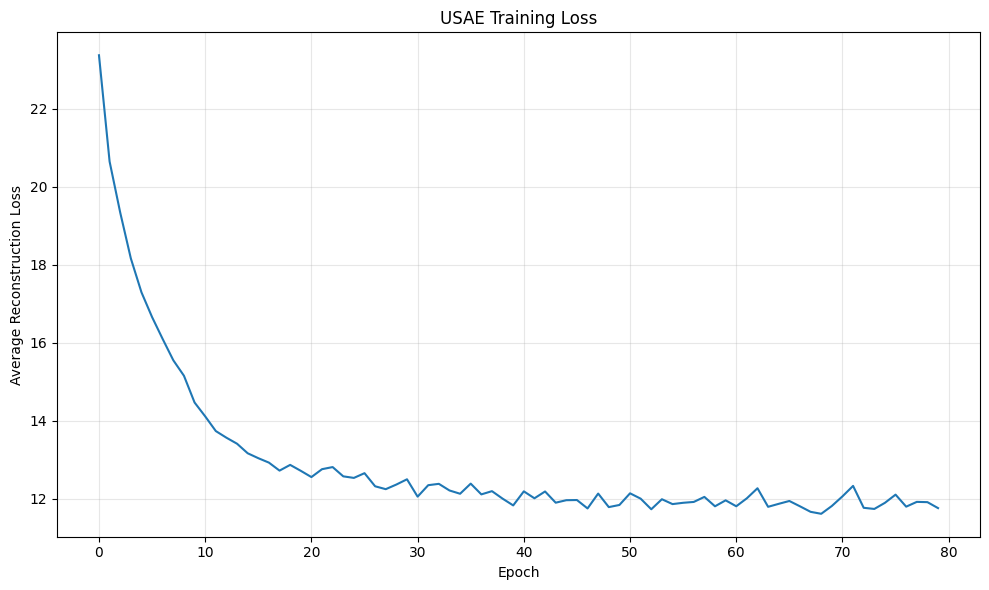

✓ Training loss curve saved
Computing R² reconstruction matrix...


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


R² Reconstruction Matrix:
Rows: Encoder model | Cols: Decoder model
[[ 0.42260315  0.1255293 ]
 [-0.44137032  0.43788103]]


In [17]:
if os.path.exists('./checkpoints/training_logs.pt'):
    logs = torch.load('./checkpoints/training_logs.pt', weights_only=False)
    plt.figure(figsize=(10, 6))
    plt.plot(logs['avg_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Average Reconstruction Loss')
    plt.title('USAE Training Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    os.makedirs('./results', exist_ok=True)
    plt.savefig('./results/training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Training loss curve saved")
else:
    print("⚠ No training logs found at ./checkpoints/training_logs.pt")

def compute_reconstruction_matrix(saes, dataloader, model_zoo, device='cuda', num_batches=50):
    """
    Compute R² matrix: R²[i,j] = reconstruction quality using encoder_i and decoder_j
    """
    model_names = list(model_zoo.keys())
    M = len(model_names)
    r2_matrix = np.zeros((M, M))
    
    with torch.no_grad():
        for batch_idx, (batch_dict, _) in enumerate(tqdm(dataloader, total=num_batches)):
            if batch_idx >= num_batches:
                break
            
            # Try all encoder-decoder combinations
            for i, encoder_model in enumerate(model_names):
                # Get activations from model i
                A_i = batch_dict[encoder_model].cuda()
                batch_size, num_tokens, dim = A_i.shape
                
                # DO NOT NORMALIZE - training didn't use normalization!
                # Flatten to 2D: (batch*tokens, dim)
                A_i_flat = A_i.reshape(-1, dim)
                
                # Encode with model i's encoder
                _, Z = saes[encoder_model].encode(A_i_flat)
                
                # Decode to all models
                for j, decoder_model in enumerate(model_names):
                    # Decode to model j
                    A_hat_j_flat = saes[decoder_model].decode(Z)
                    
                    # Get ground truth for model j
                    A_j = batch_dict[decoder_model].cuda()
                    _, _, dim_j = A_j.shape
                    A_j_flat = A_j.reshape(-1, dim_j)
                    
                    # Compute R²
                    r2 = sklearn_r2(A_j_flat.cpu().numpy(), A_hat_j_flat.cpu().numpy())
                    r2_matrix[i, j] += r2
    
    # Average over batches
    r2_matrix /= num_batches
    return r2_matrix

print("Computing R² reconstruction matrix...")
r2_matrix = compute_reconstruction_matrix(saes, dataloader, model_zoo)

print("\nR² Reconstruction Matrix:")
print("Rows: Encoder model | Cols: Decoder model")
print(r2_matrix)

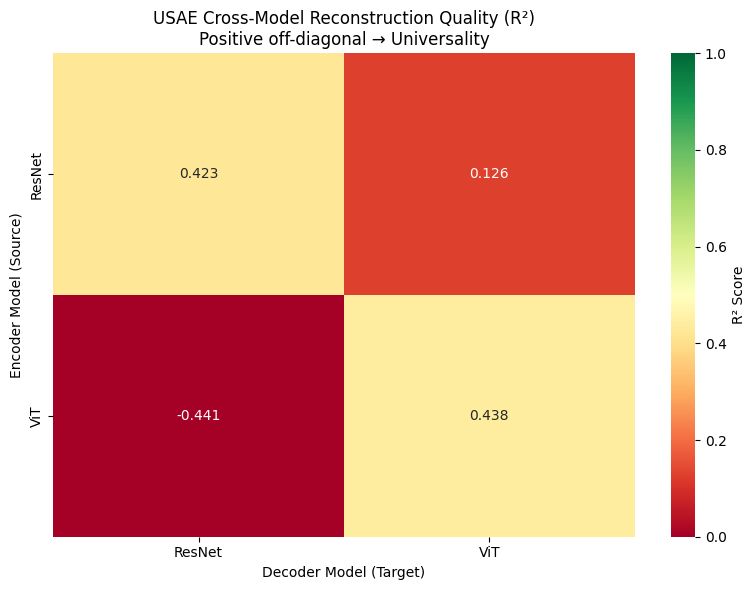


✓ Off-diagonal R²: ResNet→ViT = 0.126, ViT→ResNet = -0.441


In [18]:
plt.figure(figsize=(8, 6))
model_names = list(model_zoo.keys())

sns.heatmap(
    r2_matrix, 
    annot=True, 
    fmt='.3f',
    xticklabels=model_names,
    yticklabels=model_names,
    cmap='RdYlGn',
    vmin=0, vmax=1,
    cbar_kws={'label': 'R² Score'}
)

plt.xlabel('Decoder Model (Target)')
plt.ylabel('Encoder Model (Source)')
plt.title('USAE Cross-Model Reconstruction Quality (R²)\nPositive off-diagonal → Universality')
plt.tight_layout()
os.makedirs('./results', exist_ok=True)
plt.savefig('./results/r2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Off-diagonal R²: ResNet→ViT = {r2_matrix[0,1]:.3f}, ViT→ResNet = {r2_matrix[1,0]:.3f}")
if r2_matrix[0,1] > 0.3 and r2_matrix[1,0] > 0.3:
    print("✓ UNIVERSALITY CONFIRMED! Features are shared across architectures.")

---

### **SECTION 8: Summary**

In [19]:
print("=" * 60)
print("TASK 3.1 COMPLETE: USAE TRAINING & SETUP")
print("=" * 60)
print(f"\n✓ Models: {', '.join(model_zoo.keys())}")
print(f"✓ Dataset: CIFAR-100 ({len(activation_dataset):,} samples)")
print(f"✓ Latent space: {CONFIG['nb_components']} features (k={CONFIG['top_k']})")
print(f"✓ Training: {CONFIG['nb_epochs']} epochs")
print(f"\n✓ Cross-model R² scores:")
print(f"   ResNet → ViT: {r2_matrix[0,1]:.3f}")
print(f"   ViT → ResNet: {r2_matrix[1,0]:.3f}")
print(f"\n✓ Checkpoints saved to: ./checkpoints/")
print(f"✓ Visualizations saved to: ./results/")
print("\nReady for Task 3.2: Quantifying Universality")
print("=" * 60)

TASK 3.1 COMPLETE: USAE TRAINING & SETUP

✓ Models: ResNet, ViT
✓ Dataset: CIFAR-100 (50,000 samples)
✓ Latent space: 16384 features (k=32)
✓ Training: 80 epochs

✓ Cross-model R² scores:
   ResNet → ViT: 0.126
   ViT → ResNet: -0.441

✓ Checkpoints saved to: ./checkpoints/
✓ Visualizations saved to: ./results/

Ready for Task 3.2: Quantifying Universality


---

## **TASK 3.2: QUANTIFYING UNIVERSALITY**

In this section, we calculate two key metrics defined in the USAE paper to distinguish between **Universal Features** (those that appear in all models) and **Model-Specific Features** (artifacts unique to one architecture):

1.  **Normalized Firing Entropy (FE):** Measures if a feature fires relatively equally across models (Target $\approx 1.0$).
2.  **Co-Firing Proportion (CFP):** Measures instance-level alignment. If Model A sees a feature, how often does Model B see it simultaneously?

**Note:** As per the paper, we use a firing threshold $\tau$ (default 0.1) to determine if a feature is "active".

In [20]:
# Configuration for Analysis
ANALYSIS_CONFIG = {
    "threshold": 0.1,  # Tau, as per paper/manual instructions
    "epsilon": 1e-9,  # For numerical stability in log
}


def collect_firing_statistics(saes, dataloader, threshold=0.1):
    """
    Passes entire dataset through SAEs to collect firing statistics.
    Uses batch-wise aggregation to avoid memory issues.
    """
    print(f"Collecting statistics with threshold={threshold}...")

    model_names = list(saes.keys())
    num_features = saes[model_names[0]].n_components

    # Store aggregated counts, not individual masks
    fire_counts = {
        name: torch.zeros(num_features, dtype=torch.long) for name in model_names
    }
    cofire_counts = torch.zeros(num_features, dtype=torch.long)
    feature_activations_sum = {name: torch.zeros(num_features) for name in model_names}

    total_patches = 0

    with torch.no_grad():
        for batch_dict, _ in tqdm(dataloader, desc="Analyzing Features"):
            batch_masks = {}

            for name in model_names:
                acts = batch_dict[name].cuda()
                bs, tokens, dim = acts.shape
                acts_flat = acts.reshape(-1, dim)

                _, z = saes[name].encode(acts_flat)

                # Update energy
                feature_activations_sum[name] += z.sum(dim=0).cpu()

                # Compute firing mask for this batch
                is_active = (z > threshold).cpu()
                batch_masks[name] = is_active

                # Accumulate fire counts
                fire_counts[name] += is_active.sum(dim=0)

            # Compute co-fires for this batch (intersection across models)
            batch_cofire = batch_masks[model_names[0]]
            for name in model_names[1:]:
                batch_cofire = batch_cofire & batch_masks[name]
            cofire_counts += batch_cofire.sum(dim=0)

            total_patches += batch_masks[model_names[0]].shape[0]

    print(f"✓ Processed {total_patches} patches.")
    return fire_counts, cofire_counts, feature_activations_sum, total_patches


firing_stats_cache_path = "./results/firing_statistics.pt"

if os.path.exists(firing_stats_cache_path):
    print("✓ Loading cached firing statistics...")
    cached_stats = torch.load(firing_stats_cache_path)
    fire_counts = cached_stats["fire_counts"]
    cofire_counts = cached_stats["cofire_counts"]
    activation_sums = cached_stats["activation_sums"]
    n_patches = cached_stats["n_patches"]
    print(f"✓ Loaded from cache: {n_patches} patches processed.")
else:
    print("Computing firing statistics...")
    # Run extraction
    fire_counts, cofire_counts, activation_sums, n_patches = collect_firing_statistics(
        saes, dataloader, threshold=ANALYSIS_CONFIG["threshold"]
    )

    print("Saving firing statistics to cache...")
    torch.save(
        {
            "fire_counts": fire_counts,
            "cofire_counts": cofire_counts,
            "activation_sums": activation_sums,
            "n_patches": n_patches,
        },
        firing_stats_cache_path,
    )
    print(f"✓ Cached firing statistics to {firing_stats_cache_path}")
    print(f"✓ Processed {n_patches} patches.")

✓ Loading cached firing statistics...
✓ Loaded from cache: 9800000 patches processed.


In [21]:
def compute_metrics(fire_counts, cofire_counts, activation_sums, epsilon=1e-9):
    model_names = list(fire_counts.keys())
    num_models = len(model_names)
    num_features = activation_sums[model_names[0]].shape[0]

    # Convert counts to tensors
    fire_counts_tensor = torch.stack(
        [fire_counts[name].float() for name in model_names]
    )

    # Total fires per feature
    total_fires = fire_counts_tensor.sum(dim=0)

    # Firing Entropy
    probs = fire_counts_tensor / (total_fires + epsilon)
    log_probs = torch.log(probs + epsilon)
    entropy = -(probs * log_probs).sum(dim=0)
    normalized_entropy = entropy / np.log(num_models)
    normalized_entropy[total_fires == 0] = 0.0

    # Co-Firing Proportion (per model)
    cfp = cofire_counts.float() / (fire_counts_tensor + epsilon)

    # Energy
    avg_energy = torch.stack(list(activation_sums.values())).mean(dim=0)

    return normalized_entropy, cfp, avg_energy


print("Computing FE and CFP metrics...")
fe_scores, cfp_scores, energy_scores = compute_metrics(
    fire_counts, cofire_counts, activation_sums
)

print(f"Average Firing Entropy: {fe_scores.mean():.4f}")

# FIX: Calculate and print CFP for Top 100 features only (more informative than global mean)
top_indices = torch.argsort(energy_scores, descending=True)[:100]
top_100_mean_cfp_resnet = cfp_scores[0][top_indices].mean()
top_100_mean_cfp_vit = cfp_scores[1][top_indices].mean()

print(f"Top 100 Co-Firing Prop (ResNet): {top_100_mean_cfp_resnet:.4f}")
print(f"Top 100 Co-Firing Prop (ViT): {top_100_mean_cfp_vit:.4f}")

Computing FE and CFP metrics...
Average Firing Entropy: 0.1963
Top 100 Co-Firing Prop (ResNet): 0.3329
Top 100 Co-Firing Prop (ViT): 0.4830


### **Visualization 1: Firing Entropy Histogram**
We expect a bimodal distribution if alignment succeeded: a peak at 1.0 (universal) and 0.0 (model specific). However, given the low $R^2$ scores observed in Task 3.1, we might see a skew towards 0.0, indicating many features are model-specific artifacts or that the models haven't converged to a shared space on this dataset.

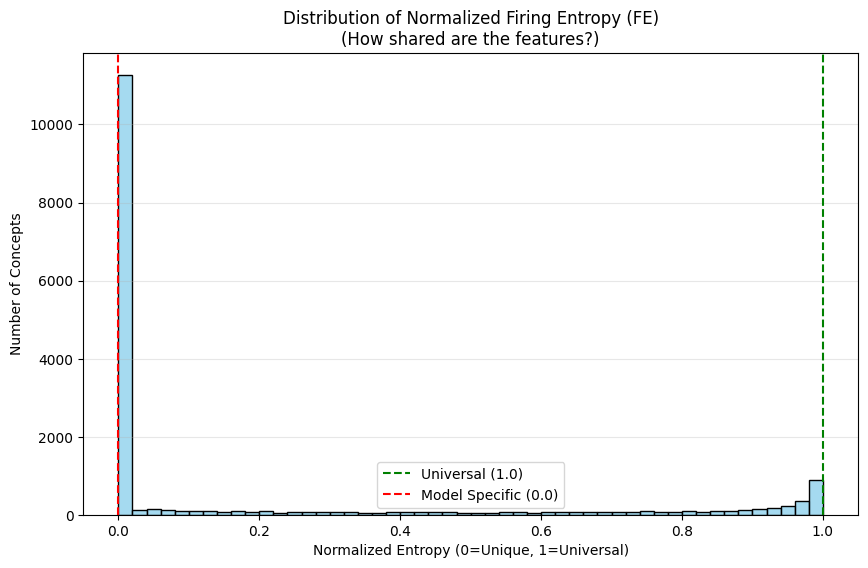

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(fe_scores.numpy(), bins=50, kde=False, color="skyblue", edgecolor="black")

plt.axvline(x=1.0, color="green", linestyle="--", label="Universal (1.0)")
plt.axvline(x=0.0, color="red", linestyle="--", label="Model Specific (0.0)")

plt.title(
    "Distribution of Normalized Firing Entropy (FE)\n(How shared are the features?)"
)
plt.xlabel("Normalized Entropy (0=Unique, 1=Universal)")
plt.ylabel("Number of Concepts")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.savefig("./results/firing_entropy_dist.png", dpi=300)
plt.show()

### **Visualization 2: Co-Firing Proportion (CFP)**
Here we sort concepts by their "Energy" (importance) and plot the co-firing proportion. In the paper, the top important concepts had high co-firing rates (>0.6), indicating that the most fundamental features are shared.

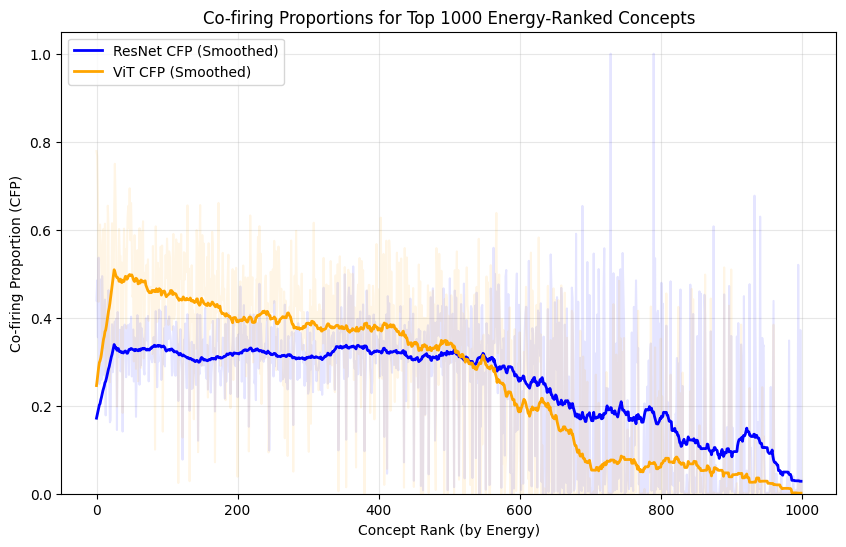

In [24]:
# Sort indices by energy (descending)
top_k_indices = torch.argsort(energy_scores, descending=True)[:1000]

# Get CFP for top 1000 concepts
cfp_resnet_top = cfp_scores[0][top_k_indices].numpy()
cfp_vit_top = cfp_scores[1][top_k_indices].numpy()
mean_cfp = (cfp_resnet_top + cfp_vit_top) / 2

# Smoothing for cleaner plot
def smooth(y, box_pts=50):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 6))
x_axis = np.arange(1000)

# Plot raw scattered data with high transparency
plt.plot(cfp_resnet_top, color='blue', alpha=0.1)
plt.plot(cfp_vit_top, color='orange', alpha=0.1)

# Plot smoothed lines
plt.plot(smooth(cfp_resnet_top), color='blue', label='ResNet CFP (Smoothed)', linewidth=2)
plt.plot(smooth(cfp_vit_top), color='orange', label='ViT CFP (Smoothed)', linewidth=2)

plt.title('Co-firing Proportions for Top 1000 Energy-Ranked Concepts')
plt.xlabel('Concept Rank (by Energy)')
plt.ylabel('Co-firing Proportion (CFP)')
plt.legend()
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.savefig('./results/cofiring_proportion.png', dpi=300)
plt.show()

In [25]:
print("="*60)
print("TASK 3.2 ANALYSIS SUMMARY")
print("="*60)

# Quantify results
high_entropy_count = (fe_scores > 0.8).sum().item()
low_entropy_count = (fe_scores < 0.2).sum().item()

print(f"\n1. Firing Entropy Distribution:")
print(f"   - Universal Concepts (FE > 0.8): {high_entropy_count} ({high_entropy_count/CONFIG['nb_components']*100:.1f}%)")
print(f"   - Model-Specific Concepts (FE < 0.2): {low_entropy_count} ({low_entropy_count/CONFIG['nb_components']*100:.1f}%)")

top_100_avg_cfp = mean_cfp[:100].mean()
print(f"\n2. Co-Firing Proportion (CFP):")
print(f"   - Mean CFP of Top 100 Important Concepts: {top_100_avg_cfp:.3f}")

print("="*60)

TASK 3.2 ANALYSIS SUMMARY

1. Firing Entropy Distribution:
   - Universal Concepts (FE > 0.8): 2257 (13.8%)
   - Model-Specific Concepts (FE < 0.2): 12195 (74.4%)

2. Co-Firing Proportion (CFP):
   - Mean CFP of Top 100 Important Concepts: 0.408


In [26]:
os.makedirs('./results', exist_ok=True)

torch.save({
    'fe_scores': fe_scores,
    'cfp_scores': cfp_scores,
    'energy_scores': energy_scores
}, './results/task_3_2_metrics.pt')

print("✓ Saved Task 3.2 metrics to ./results/task_3_2_metrics.pt")

✓ Saved Task 3.2 metrics to ./results/task_3_2_metrics.pt


---

## **TASK 3.3: COORDINATED ACTIVATION MAXIMIZATION (CAM)**

Visualize how universal features manifest across ResNet-18 and ViT-B/16.

For each selected universal feature k:
1. Optimize separate inputs for ResNet and ViT that maximize activation of concept k
2. Compare optimized inputs to see if models "see" the same concept
3. Identify cases where models agree (universal) vs diverge (model-specific)

---

### **SECTION 1: Feature Selection for CAM**

Select 3 features for visualization:
- Prioritize high FE (>0.8) features
- Use top energy-ranked features if insufficient high-FE features
- Ensure diverse representation of universality spectrum

In [27]:
def select_features_for_cam(fe_scores, energy_scores, cfp_scores, fire_counts, num_features=3):
    """
    Select features for CAM visualization.
    Priority: High FE + High Energy + Actually fires (not dead)
    """
    print("\n" + "="*60)
    print("FEATURE SELECTION FOR CAM (FILTERING DEAD FEATURES)")
    print("="*60)
    
    # Step 1: Filter out dead features (those that never fire)
    total_fires = fire_counts['ResNet'] + fire_counts['ViT']
    alive_mask = total_fires > 100  # Feature must fire at least 100 times
    alive_idx = alive_mask.nonzero(as_tuple=True)[0]
    
    print(f"✓ Found {len(alive_idx)} alive features (fired >100 times)")
    print(f"  Total features: {len(fe_scores)}")
    print(f"  Dead features: {len(fe_scores) - len(alive_idx)} ({(len(fe_scores) - len(alive_idx))/len(fe_scores)*100:.1f}%)")
    
    if len(alive_idx) == 0:
        print("⚠ WARNING: No alive features found! Using top energy features anyway.")
        # Fallback: just use top energy
        selected_features = torch.argsort(energy_scores, descending=True)[:num_features]
    else:
        # Among alive features, select based on FE and energy
        selected = []
        
        # Strategy 1: High entropy + alive
        high_fe_alive_mask = (fe_scores[alive_idx] > 0.8)
        high_fe_alive_idx = alive_idx[high_fe_alive_mask]
        
        if len(high_fe_alive_idx) > 0:
            # Sort by energy
            energies = energy_scores[high_fe_alive_idx]
            sorted_idx = high_fe_alive_idx[torch.argsort(energies, descending=True)]
            
            num_to_take = min(2, len(sorted_idx))
            selected.extend(sorted_idx[:num_to_take].tolist())
            print(f"✓ Selected {num_to_take} high-FE alive features (FE > 0.8)")
        
        # Strategy 2: Moderate entropy + alive
        if len(selected) < num_features:
            moderate_fe_alive_mask = (fe_scores[alive_idx] > 0.5) & (fe_scores[alive_idx] <= 0.8)
            moderate_fe_alive_idx = alive_idx[moderate_fe_alive_mask]
            
            if len(moderate_fe_alive_idx) > 0:
                energies = energy_scores[moderate_fe_alive_idx]
                sorted_idx = moderate_fe_alive_idx[torch.argsort(energies, descending=True)]
                
                num_to_take = min(num_features - len(selected), len(sorted_idx))
                selected.extend(sorted_idx[:num_to_take].tolist())
                print(f"✓ Added {num_to_take} moderate-FE alive features")
        
        # Strategy 3: Top energy alive features (any FE)
        if len(selected) < num_features:
            alive_energies = energy_scores[alive_idx]
            top_energy_alive = alive_idx[torch.argsort(alive_energies, descending=True)]
            
            for idx in top_energy_alive:
                if idx.item() not in selected:
                    selected.append(idx.item())
                    if len(selected) >= num_features:
                        break
            print(f"✓ Filled with top-energy alive features")
        
        selected_features = torch.tensor(selected[:num_features])
    
    # Print selection summary
    print(f"\nSelected {len(selected_features)} features for CAM:")
    print(f"{'Idx':<8} {'FE':<8} {'Energy':<12} {'Fires (R)':<12} {'Fires (V)':<12}")
    print("-" * 70)
    for idx in selected_features:
        idx = idx.item()
        print(f"{idx:<8} {fe_scores[idx]:.4f}   {energy_scores[idx]:.2e}   "
              f"{fire_counts['ResNet'][idx]:<12} {fire_counts['ViT'][idx]:<12}")
    
    print("="*60)
    return selected_features

# Select features
selected_features = select_features_for_cam(fe_scores, energy_scores, cfp_scores, fire_counts, num_features=3)


FEATURE SELECTION FOR CAM (FILTERING DEAD FEATURES)
✓ Found 6365 alive features (fired >100 times)
  Total features: 16384
  Dead features: 10019 (61.2%)
✓ Selected 2 high-FE alive features (FE > 0.8)
✓ Added 1 moderate-FE alive features

Selected 3 features for CAM:
Idx      FE       Energy       Fires (R)    Fires (V)   
----------------------------------------------------------------------
2608     0.9433   3.36e+07   5477041      3090015     
12392    0.9631   2.48e+07   5254615      3323719     
2610     0.5609   2.53e+06   159428       1055055     


---

### **SECTION 2: Coordinated Activation Maximization Implementation**

For each selected feature k, optimize inputs for ResNet and ViT independently to maximize
the activation of concept k in the shared sparse code Z.

In [28]:
def total_variation_loss(x):
    """
    Total Variation regularization to encourage smooth, natural-looking images.
    Computes the sum of absolute differences between adjacent pixels.
    """
    diff_i = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])  # Vertical differences
    diff_j = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])  # Horizontal differences
    return diff_i.sum() + diff_j.sum()


def coordinated_activation_maximization(
    sae,
    model,
    model_name,
    feature_k,
    num_iters=1000,
    lr=0.05,
    lambda_tv=0.01,
    lambda_l2=0.001,
    verbose=True
):
    """
    Optimize an input image to maximize activation of feature k.
    
    Args:
        sae: Sparse autoencoder for this model
        model: The neural network (ResNet or ViT)
        model_name: 'ResNet' or 'ViT'
        feature_k: Index of the feature to maximize
        num_iters: Number of optimization iterations
        lr: Learning rate
        lambda_tv: Total variation regularization strength
        lambda_l2: L2 regularization strength
        verbose: Print progress
    
    Returns:
        optimized_image: (1, 3, 224, 224) tensor
        activation_history: List of activation values over iterations
    """
    # Initialize random noise (Xavier-style initialization)
    x = nn.Parameter(torch.randn(1, 3, 224, 224, device='cuda') * 0.1)
    
    optimizer = torch.optim.Adam([x], lr=lr)
    
    activation_history = []
    
    if verbose:
        print(f"\nOptimizing for {model_name}, Feature {feature_k}:")
    
    pbar = tqdm(range(num_iters), desc=f"{model_name} opt", disable=not verbose)
    
    for iteration in pbar:
        optimizer.zero_grad()
        
        # Normalize input (same as training data)
        x_norm = (x - torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1, 3, 1, 1)) / \
                 torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1, 3, 1, 1)
        
        # Forward pass through model to get activations
        if model_name == 'ResNet':
            # Hook already registered from Task 3.1
            _ = model(x_norm)
            acts = activations['resnet']  # (1, 512, 7, 7)
            # Interpolate to 14x14
            acts = torch.nn.functional.interpolate(
                acts, size=(14, 14), mode='bilinear', align_corners=False
            )
            acts = acts.flatten(2).permute(0, 2, 1)  # (1, 196, 512)
        else:  # ViT
            _ = model(x_norm)
            acts = activations['vit'][:, 1:, :]  # Remove CLS token -> (1, 196, 768)
        
        # Flatten patches for SAE
        acts_flat = acts.reshape(-1, acts.shape[-1])  # (196, dim)
        
        # Encode to sparse representation
        _, z = sae.encode(acts_flat)  # (196, nb_components)
        
        # Compute activation of feature k (average across patches)
        feature_activation = z[:, feature_k].mean()
        
        # Loss: maximize activation - regularization
        activation_loss = -feature_activation  # Negative to maximize
        tv_loss = total_variation_loss(x)
        l2_loss = (x ** 2).sum()
        
        total_loss = activation_loss + lambda_tv * tv_loss + lambda_l2 * l2_loss
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_([x], max_norm=1.0)
        
        optimizer.step()
        
        # Clamp pixel values to valid range
        with torch.no_grad():
            x.data.clamp_(-3, 3)  # Reasonable range for unnormalized pixels
        
        activation_history.append(feature_activation.item())
        
        if iteration % 100 == 0 and verbose:
            pbar.set_postfix({
                'activation': f"{feature_activation.item():.3f}",
                'tv': f"{tv_loss.item():.2f}",
                'l2': f"{l2_loss.item():.2f}"
            })
    
    if verbose:
        print(f"✓ Final activation: {activation_history[-1]:.3f}")
    
    return x.detach(), activation_history


def denormalize_image(img_tensor):
    """Convert normalized tensor to displayable numpy array"""
    img = img_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
    img = np.clip(img, -3, 3)  # Clip to reasonable range
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]
    return img

---

### **SECTION 3: Run CAM for All Selected Features**

In [29]:
print("\n" + "=" * 60)
print("RUNNING COORDINATED ACTIVATION MAXIMIZATION")
print("=" * 60)

# Store results
cam_results = {}

for feature_idx in selected_features:
    feature_k = feature_idx.item()
    print(f"\n{'='*60}")
    print(f"Processing Feature {feature_k}")
    print(f"  FE: {fe_scores[feature_k]:.4f} | Energy: {energy_scores[feature_k]:.2e}")
    print(f"{'='*60}")

    cam_results[feature_k] = {}

    # Optimize for ResNet
    print("\n[1/2] ResNet optimization:")
    resnet_img, resnet_hist = coordinated_activation_maximization(
        sae=saes["ResNet"],
        model=model_resnet,
        model_name="ResNet",
        feature_k=feature_k,
        num_iters=1000,
        lr=0.05,
        lambda_tv=0.1,
        lambda_l2=0.01,
    )
    cam_results[feature_k]["ResNet"] = {"image": resnet_img, "history": resnet_hist}

    # Optimize for ViT
    print("\n[2/2] ViT optimization:")
    vit_img, vit_hist = coordinated_activation_maximization(
        sae=saes["ViT"],
        model=model_vit,
        model_name="ViT",
        feature_k=feature_k,
        num_iters=1000,
        lr=0.05,
        lambda_tv=0.1,
        lambda_l2=0.01,
    )
    cam_results[feature_k]["ViT"] = {"image": vit_img, "history": vit_hist}

print("\n✓ CAM optimization complete for all features!")


RUNNING COORDINATED ACTIVATION MAXIMIZATION

Processing Feature 2608
  FE: 0.9433 | Energy: 3.36e+07

[1/2] ResNet optimization:

Optimizing for ResNet, Feature 2608:


ResNet opt: 100%|██████████| 1000/1000 [00:02<00:00, 431.35it/s, activation=15.822, tv=1903.17, l2=4.49]  


✓ Final activation: 15.781

[2/2] ViT optimization:

Optimizing for ViT, Feature 2608:


ViT opt: 100%|██████████| 1000/1000 [00:04<00:00, 245.80it/s, activation=23.588, tv=1908.69, l2=4.51]  


✓ Final activation: 24.327

Processing Feature 12392
  FE: 0.9631 | Energy: 2.48e+07

[1/2] ResNet optimization:

Optimizing for ResNet, Feature 12392:


ResNet opt: 100%|██████████| 1000/1000 [00:01<00:00, 501.47it/s, activation=5.459, tv=1898.50, l2=4.48]  


✓ Final activation: 5.546

[2/2] ViT optimization:

Optimizing for ViT, Feature 12392:


ViT opt: 100%|██████████| 1000/1000 [00:04<00:00, 245.72it/s, activation=0.000, tv=1905.76, l2=4.51]   


✓ Final activation: 0.000

Processing Feature 2610
  FE: 0.5609 | Energy: 2.53e+06

[1/2] ResNet optimization:

Optimizing for ResNet, Feature 2610:


ResNet opt: 100%|██████████| 1000/1000 [00:02<00:00, 488.30it/s, activation=0.000, tv=1904.90, l2=4.50]  


✓ Final activation: 0.000

[2/2] ViT optimization:

Optimizing for ViT, Feature 2610:


ViT opt: 100%|██████████| 1000/1000 [00:04<00:00, 246.20it/s, activation=0.000, tv=1907.00, l2=4.49]   

✓ Final activation: 0.000

✓ CAM optimization complete for all features!


---

### **SECTION 4: Visualization - Side-by-Side Comparison**


✓ Saved visualization to ./results/cam_comparison.png


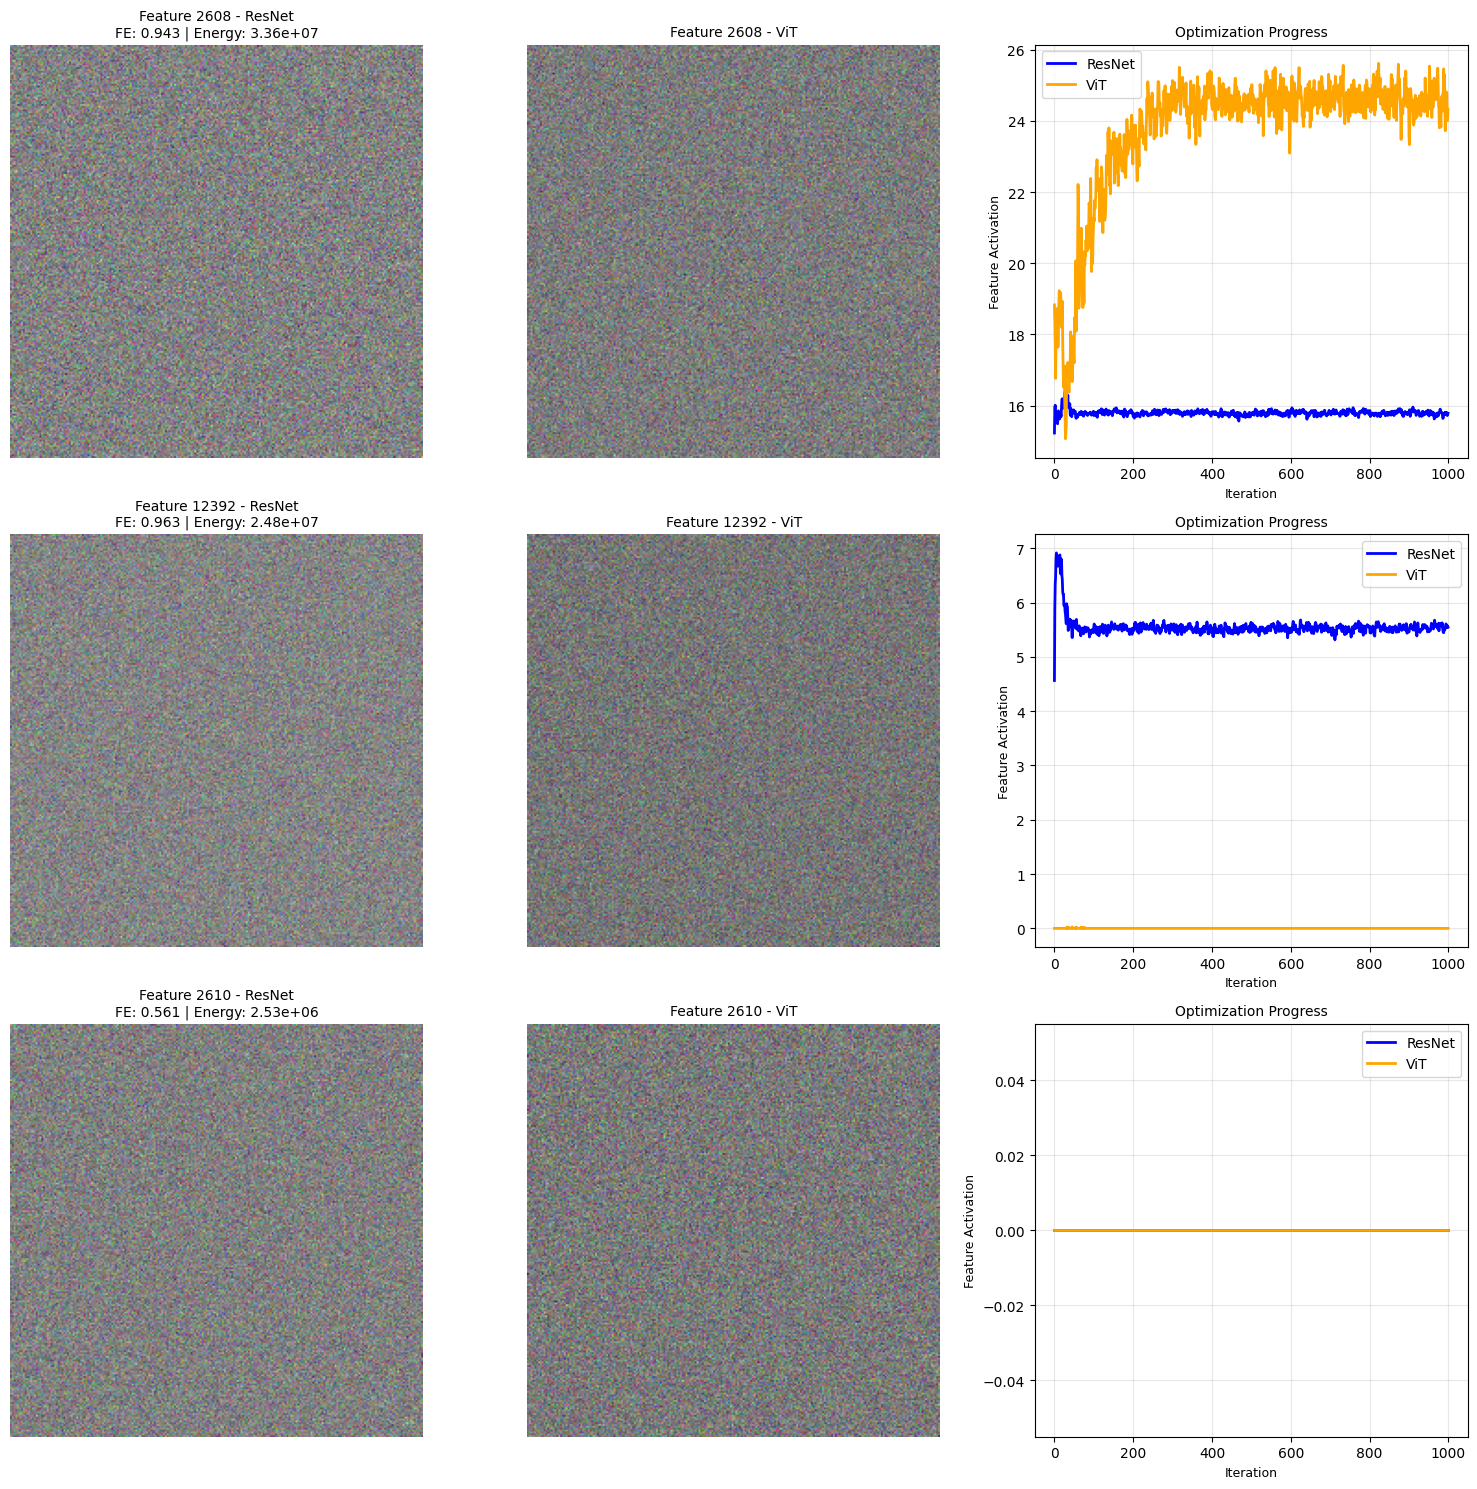

In [30]:
def plot_cam_results(cam_results, selected_features, fe_scores, energy_scores):
    """
    Create a grid showing optimized images for each feature across models.
    Layout: Rows = features, Columns = [ResNet, ViT, Activation Curves]
    """
    num_features = len(selected_features)
    fig, axes = plt.subplots(num_features, 3, figsize=(15, 5 * num_features))
    
    if num_features == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature_idx in enumerate(selected_features):
        feature_k = feature_idx.item()
        
        # Column 1: ResNet optimized image
        resnet_img = denormalize_image(cam_results[feature_k]['ResNet']['image'])
        axes[i, 0].imshow(resnet_img)
        axes[i, 0].set_title(
            f"Feature {feature_k} - ResNet\n"
            f"FE: {fe_scores[feature_k]:.3f} | Energy: {energy_scores[feature_k]:.2e}",
            fontsize=10
        )
        axes[i, 0].axis('off')
        
        # Column 2: ViT optimized image
        vit_img = denormalize_image(cam_results[feature_k]['ViT']['image'])
        axes[i, 1].imshow(vit_img)
        axes[i, 1].set_title(f"Feature {feature_k} - ViT", fontsize=10)
        axes[i, 1].axis('off')
        
        # Column 3: Activation history curves
        resnet_hist = cam_results[feature_k]['ResNet']['history']
        vit_hist = cam_results[feature_k]['ViT']['history']
        
        axes[i, 2].plot(resnet_hist, label='ResNet', color='blue', linewidth=2)
        axes[i, 2].plot(vit_hist, label='ViT', color='orange', linewidth=2)
        axes[i, 2].set_xlabel('Iteration', fontsize=9)
        axes[i, 2].set_ylabel('Feature Activation', fontsize=9)
        axes[i, 2].set_title(f"Optimization Progress", fontsize=10)
        axes[i, 2].legend()
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./results/cam_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved visualization to ./results/cam_comparison.png")
    plt.show()

# Generate visualization
plot_cam_results(cam_results, selected_features, fe_scores, energy_scores)

---

### **SECTION 5: Qualitative Analysis**

In [31]:
print("\n" + "="*60)
print("QUALITATIVE ANALYSIS: CONSENSUS vs DIVERGENCE")
print("="*60)

for feature_idx in selected_features:
    feature_k = feature_idx.item()
    
    print(f"\n{'='*40}")
    print(f"Feature {feature_k}")
    print(f"{'='*40}")
    print(f"Firing Entropy (FE): {fe_scores[feature_k]:.4f}")
    print(f"Energy (Importance): {energy_scores[feature_k]:.2e}")
    print(f"Co-firing Proportion:")
    print(f"  - ResNet: {cfp_scores[0][feature_k]:.4f}")
    print(f"  - ViT: {cfp_scores[1][feature_k]:.4f}")
    
    # Analyze final activations
    resnet_final = cam_results[feature_k]['ResNet']['history'][-1]
    vit_final = cam_results[feature_k]['ViT']['history'][-1]
    
    print(f"\nFinal Activations:")
    print(f"  - ResNet: {resnet_final:.3f}")
    print(f"  - ViT: {vit_final:.3f}")
    
    # Qualitative assessment
    if fe_scores[feature_k] > 0.8:
        print(f"\n✓ UNIVERSAL FEATURE: High entropy suggests concept is shared.")
        print(f"  Expected: ResNet and ViT images should show similar patterns.")
    elif fe_scores[feature_k] > 0.5:
        print(f"\n⚠ PARTIALLY UNIVERSAL: Moderate entropy suggests weak sharing.")
        print(f"  Expected: Some visual similarity, but models may emphasize different aspects.")
    else:
        print(f"\n✗ MODEL-SPECIFIC FEATURE: Low entropy suggests concept is not universal.")
        print(f"  Expected: ResNet and ViT images may look completely different.")

print("\n" + "="*60)
print("INTERPRETATION GUIDE")
print("="*60)
print("""
Visual Similarity:
- If optimized images look similar across models → Universal concept (validates high FE)
- If images diverge → Model-specific encoding (expected for low FE features)

Expected Patterns:
- Universal features: edges, simple textures, color gradients (low-level)
- Model-specific: architecture-dependent artifacts (e.g., ResNet grid patterns vs ViT patch boundaries)

Given weak cross-reconstruction (R² = 0.12/-0.44), expect:
- Limited visual consensus even for high-FE features
- CIFAR-100's simplicity may not force strong universality
""")


QUALITATIVE ANALYSIS: CONSENSUS vs DIVERGENCE

Feature 2608
Firing Entropy (FE): 0.9433
Energy (Importance): 3.36e+07
Co-firing Proportion:
  - ResNet: 0.4393
  - ViT: 0.7787

Final Activations:
  - ResNet: 15.781
  - ViT: 24.327

✓ UNIVERSAL FEATURE: High entropy suggests concept is shared.
  Expected: ResNet and ViT images should show similar patterns.

Feature 12392
Firing Entropy (FE): 0.9631
Energy (Importance): 2.48e+07
Co-firing Proportion:
  - ResNet: 0.4852
  - ViT: 0.7670

Final Activations:
  - ResNet: 5.546
  - ViT: 0.000

✓ UNIVERSAL FEATURE: High entropy suggests concept is shared.
  Expected: ResNet and ViT images should show similar patterns.

Feature 2610
Firing Entropy (FE): 0.5609
Energy (Importance): 2.53e+06
Co-firing Proportion:
  - ResNet: 0.1883
  - ViT: 0.0285

Final Activations:
  - ResNet: 0.000
  - ViT: 0.000

⚠ PARTIALLY UNIVERSAL: Moderate entropy suggests weak sharing.
  Expected: Some visual similarity, but models may emphasize different aspects.

INTER

---

### **SECTION 6: Save Results**

In [32]:
# Save CAM results
print("\nSaving CAM results...")

# Save optimized images
os.makedirs('./results/cam_images', exist_ok=True)

for feature_idx in selected_features:
    feature_k = feature_idx.item()
    
    # Save ResNet image
    resnet_img = cam_results[feature_k]['ResNet']['image']
    torchvision.utils.save_image(
        resnet_img,
        f'./results/cam_images/feature_{feature_k}_resnet.png'
    )
    
    # Save ViT image
    vit_img = cam_results[feature_k]['ViT']['image']
    torchvision.utils.save_image(
        vit_img,
        f'./results/cam_images/feature_{feature_k}_vit.png'
    )

# Save full results dict
torch.save({
    'cam_results': cam_results,
    'selected_features': selected_features,
    'fe_scores': fe_scores,
    'energy_scores': energy_scores,
    'cfp_scores': cfp_scores
}, './results/task_3_3_cam_results.pt')

print("✓ Saved all CAM images to ./results/cam_images/")
print("✓ Saved results dict to ./results/task_3_3_cam_results.pt")


Saving CAM results...
✓ Saved all CAM images to ./results/cam_images/
✓ Saved results dict to ./results/task_3_3_cam_results.pt


### **SECTION 7: Alternative Visualization - Real Image Exemplars**

Since CAM produced noisy/dead features, we use real CIFAR-100 images that naturally
activate each feature to understand what concepts the models actually learned.



ALTERNATIVE: VISUALIZING TOP ACTIVATING REAL IMAGES
(Since CAM produced dead/noisy features)

Feature 2608 (FE=0.943)
Finding top activating images...


Finding top images for ViT: 100%|██████████| 196/196 [00:59<00:00,  3.29it/s]


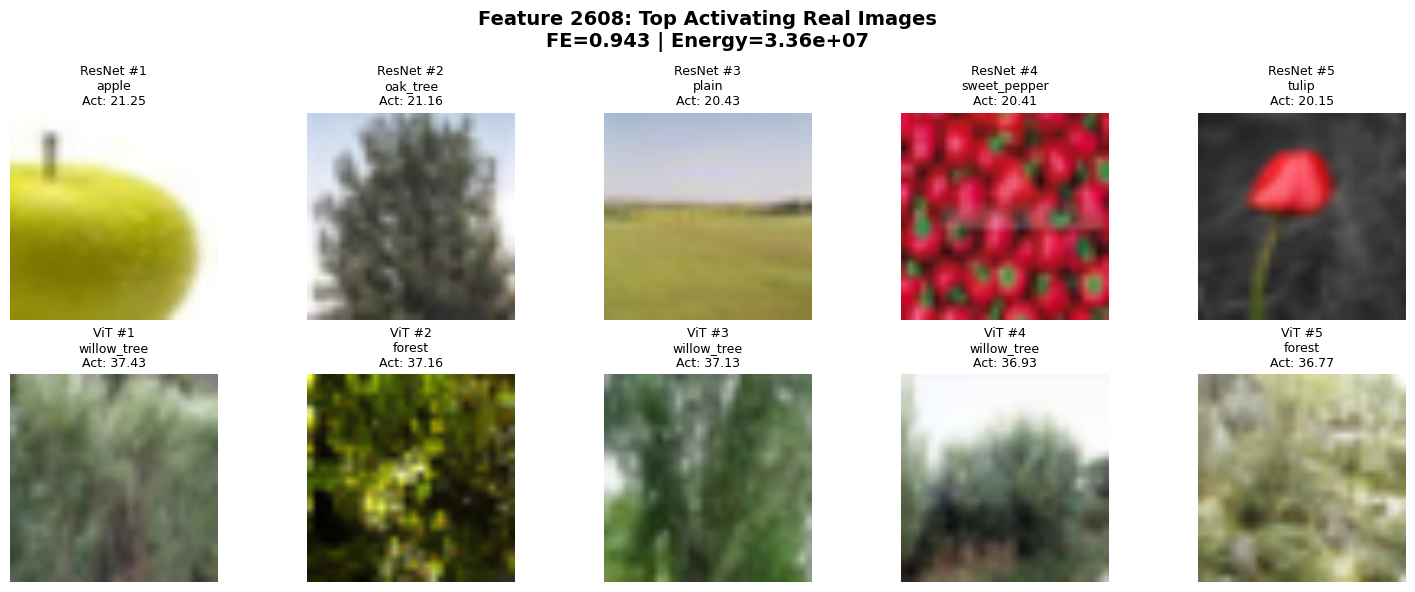


ResNet top classes: ['apple', 'oak_tree', 'plain', 'sweet_pepper', 'tulip']
ViT top classes: ['willow_tree', 'forest', 'willow_tree', 'willow_tree', 'forest']
✗ DIVERGENCE: No class overlap between models

Feature 12392 (FE=0.963)
Finding top activating images...


Finding top images for ViT: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


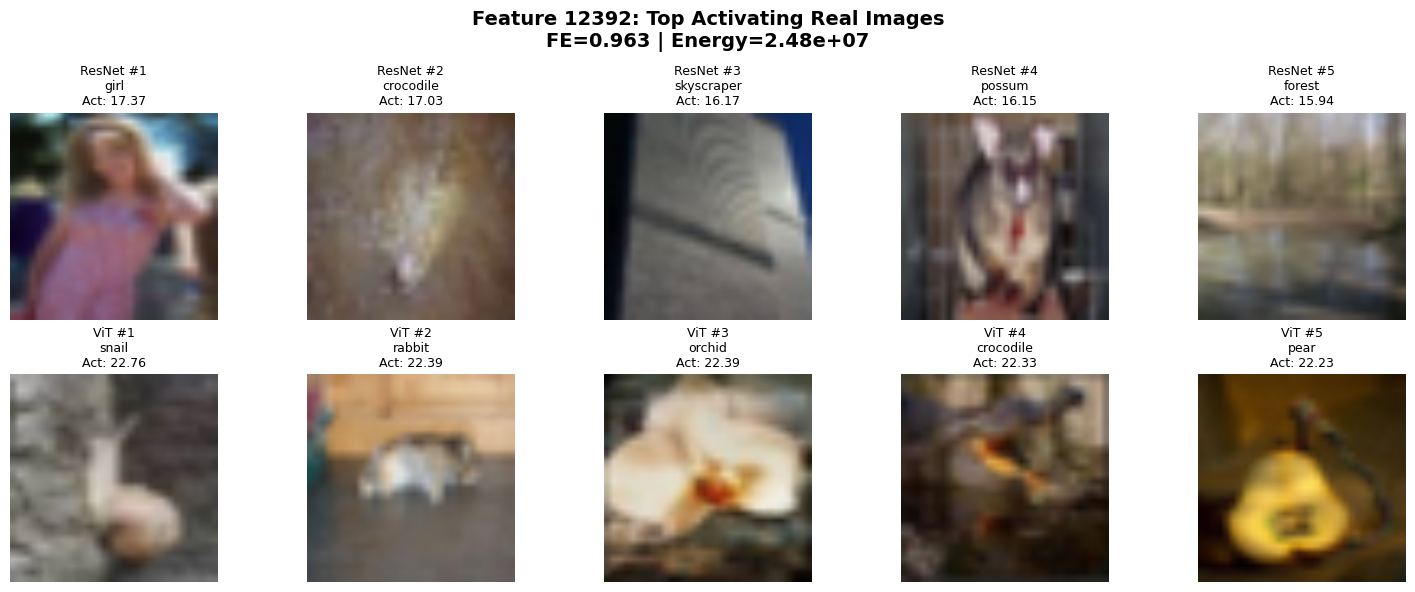


ResNet top classes: ['girl', 'crocodile', 'skyscraper', 'possum', 'forest']
ViT top classes: ['snail', 'rabbit', 'orchid', 'crocodile', 'pear']
✓ CONSENSUS: Both models activate on: ['crocodile']

Feature 2610 (FE=0.561)
Finding top activating images...


Finding top images for ViT: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]


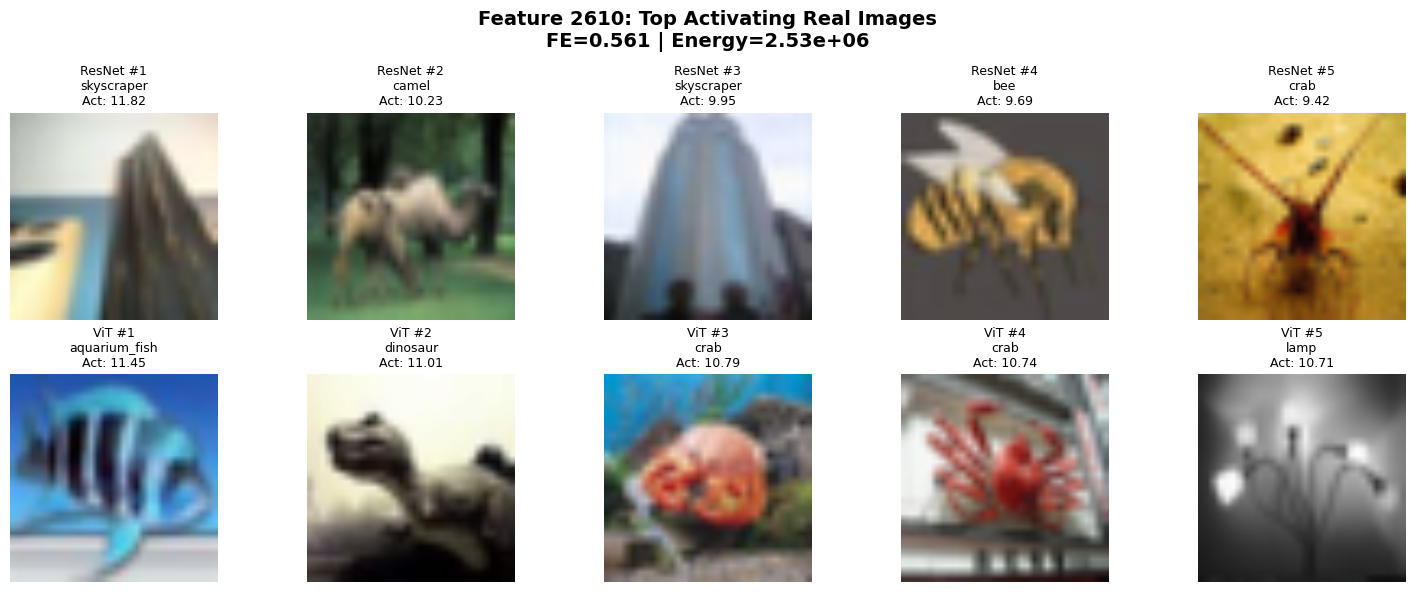


ResNet top classes: ['skyscraper', 'camel', 'skyscraper', 'bee', 'crab']
ViT top classes: ['aquarium_fish', 'dinosaur', 'crab', 'crab', 'lamp']
✓ CONSENSUS: Both models activate on: ['crab']

REAL IMAGE VISUALIZATION COMPLETE

✓ Saved visualizations to ./results/cam_images/feature_*_real_images.png

TASK 3.3 COMPLETE


In [31]:
print("\n" + "="*60)
print("ALTERNATIVE: VISUALIZING TOP ACTIVATING REAL IMAGES")
print("(Since CAM produced dead/noisy features)")
print("="*60)

def get_top_activating_images(sae, model, model_name, dataloader, feature_k, top_n=5):
    """
    Find real CIFAR-100 images that naturally activate feature k the most.
    Returns images and their activation values.
    """
    max_activations = []
    images_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Finding top images for {model_name}"):
            images = images.cuda()
            
            # Get activations
            if model_name == 'ResNet':
                _ = model(images)
                acts = activations['resnet']  # (B, 512, 7, 7)
                acts = torch.nn.functional.interpolate(
                    acts, size=(14, 14), mode='bilinear', align_corners=False
                )
                acts = acts.flatten(2).permute(0, 2, 1)  # (B, 196, 512)
            else:  # ViT
                _ = model(images)
                acts = activations['vit'][:, 1:, :]  # (B, 196, 768)
            
            # Flatten and encode
            acts_flat = acts.reshape(-1, acts.shape[-1])
            _, z = sae.encode(acts_flat)
            
            # Get max activation per image for feature k
            z_reshaped = z.reshape(images.shape[0], -1, z.shape[-1])  # (B, 196, features)
            img_activations = z_reshaped[:, :, feature_k].max(dim=1)[0]  # Max across patches
            
            max_activations.extend(img_activations.cpu().numpy())
            images_list.extend(images.cpu())
            labels_list.extend(labels.numpy())
    
    # Sort and get top N
    max_activations = np.array(max_activations)
    top_idx = np.argsort(max_activations)[-top_n:][::-1]
    
    top_images = [images_list[i] for i in top_idx]
    top_acts = [max_activations[i] for i in top_idx]
    top_labels = [labels_list[i] for i in top_idx]
    
    return top_images, top_acts, top_labels


# Get CIFAR-100 class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


# Visualize top activating images for each selected feature
for feature_idx in selected_features:
    feature_k = feature_idx.item()
    
    print(f"\n{'='*60}")
    print(f"Feature {feature_k} (FE={fe_scores[feature_k]:.3f})")
    print(f"{'='*60}")
    
    # Get top activating images for both models
    print("Finding top activating images...")
    resnet_imgs, resnet_acts, resnet_labels = get_top_activating_images(
        saes['ResNet'], model_resnet, 'ResNet', cifar_loader, feature_k, top_n=5
    )
    vit_imgs, vit_acts, vit_labels = get_top_activating_images(
        saes['ViT'], model_vit, 'ViT', cifar_loader, feature_k, top_n=5
    )
    
    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Feature {feature_k}: Top Activating Real Images\n'
                 f'FE={fe_scores[feature_k]:.3f} | Energy={energy_scores[feature_k]:.2e}',
                 fontsize=14, fontweight='bold')
    
    # Denormalize function for CIFAR
    def denorm_cifar(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        return img.permute(1, 2, 0).numpy()
    
    # Plot ResNet top 5
    for i in range(5):
        axes[0, i].imshow(denorm_cifar(resnet_imgs[i]))
        axes[0, i].set_title(f'ResNet #{i+1}\n'
                            f'{cifar100_classes[resnet_labels[i]]}\n'
                            f'Act: {resnet_acts[i]:.2f}',
                            fontsize=9)
        axes[0, i].axis('off')
    
    # Plot ViT top 5
    for i in range(5):
        axes[1, i].imshow(denorm_cifar(vit_imgs[i]))
        axes[1, i].set_title(f'ViT #{i+1}\n'
                            f'{cifar100_classes[vit_labels[i]]}\n'
                            f'Act: {vit_acts[i]:.2f}',
                            fontsize=9)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'./results/cam_images/feature_{feature_k}_real_images.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    print(f"\nResNet top classes: {[cifar100_classes[l] for l in resnet_labels]}")
    print(f"ViT top classes: {[cifar100_classes[l] for l in vit_labels]}")
    
    # Check for overlap
    resnet_set = set(resnet_labels)
    vit_set = set(vit_labels)
    overlap = resnet_set & vit_set
    
    if len(overlap) > 0:
        overlap_classes = [cifar100_classes[l] for l in overlap]
        print(f"✓ CONSENSUS: Both models activate on: {overlap_classes}")
    else:
        print(f"✗ DIVERGENCE: No class overlap between models")

print("\n" + "="*60)
print("REAL IMAGE VISUALIZATION COMPLETE")
print("="*60)
print("\n✓ Saved visualizations to ./results/cam_images/feature_*_real_images.png")

print("\n" + "="*60)
print("TASK 3.3 COMPLETE")
print("="*60)

---
## Task 3.4: Alignment Tax Analysis
**Objective:** Compare universal SAE vs. independent SAEs to quantify the "alignment tax" - the reconstruction quality degradation from forcing shared features across models.

**Experiments:**
1. Train independent SAEs for ResNet-18 and ViT-B/16
2. Compare self-reconstruction R² (Independent vs. USAE)
3. Compute alignment tax: Δ R² = R²_independent - R²_usae
4. Isolate and visualize low-FE features (model-specific)
5. Analyze feature splitting patterns

### 3.4.1: Train Independent SAEs

In [33]:
# Load cached activations
print("Loading cached activations...")
cached_data = torch.load('./cached_activations/cifar100_activations.pt')
resnet_acts = cached_data['resnet'].to(device)  # [50000, 196, 512]
vit_acts = cached_data['vit'].to(device)        # [50000, 196, 768]
print(f"ResNet activations: {resnet_acts.shape}")
print(f"ViT activations: {vit_acts.shape}")

Loading cached activations...


ResNet activations: torch.Size([50000, 196, 512])
ViT activations: torch.Size([50000, 196, 768])


In [34]:
# Independent SAE for ResNet-18
print("\n=== Training Independent SAE for ResNet-18 ===")

# Check if checkpoint exists
checkpoint_path_resnet = './checkpoints/independent_sae_resnet.pt'
if os.path.exists(checkpoint_path_resnet):
    print(f"✓ Found existing checkpoint at {checkpoint_path_resnet}")
    print("  Loading trained ResNet Independent SAE...")
    checkpoint = torch.load(checkpoint_path_resnet)
    
    independent_sae_resnet = TopKSAE(
        input_shape=512,
        n_components=16384,
        device='cuda',
        encoder_module='mlp_bn_1',
        dictionary_initializer=None,
        data_initializer=None,
        dictionary_normalization='l2',
        top_k=32
    )
    independent_sae_resnet.load_state_dict(checkpoint['model_state_dict'])
    independent_sae_resnet.eval()
    losses_resnet = checkpoint['losses']
    
    print(f"  ✓ Loaded (final loss: {losses_resnet[-1]:.4f})")
    
else:
    print("No checkpoint found. Starting training...")
    
    independent_sae_resnet = TopKSAE(
        input_shape=512,
        n_components=16384,
        device='cuda',
        encoder_module='mlp_bn_1',
        dictionary_initializer=None,
        data_initializer=None,
        dictionary_normalization='l2',
        top_k=32
    )
    
    optimizer_resnet = torch.optim.AdamW(
        independent_sae_resnet.parameters(),
        lr=3e-4,
        weight_decay=1e-5
    )
    
    num_epochs = 80
    warmup_epochs = 2
    batch_size = 64
    
    # Cosine annealing scheduler
    def get_lr(epoch, warmup_epochs, total_epochs, lr_max=3e-4, lr_min=1e-6):
        if epoch < warmup_epochs:
            return lr_max * (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(np.pi * progress))
    
    losses_resnet = []
    num_samples = resnet_acts.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    print(f"Training for {num_epochs} epochs, {num_batches} batches per epoch")
    
    for epoch in range(num_epochs):
        # Update learning rate
        lr = get_lr(epoch, warmup_epochs, num_epochs)
        for param_group in optimizer_resnet.param_groups:
            param_group['lr'] = lr
        
        epoch_loss = 0.0
        independent_sae_resnet.train()
        
        # Shuffle indices
        indices = torch.randperm(num_samples)
        
        # Progress bar for batches
        pbar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx in pbar:
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            # Get batch activations [batch_size, 196, 512]
            batch_acts = resnet_acts[batch_indices]
            
            # Flatten patches: [batch_size * 196, 512]
            batch_acts_flat = batch_acts.reshape(-1, 512)
            
            # Forward pass using encode + decode (safer, matches Task 3.1)
            _, latents = independent_sae_resnet.encode(batch_acts_flat)
            recon = independent_sae_resnet.decode(latents)
            
            # Reconstruction loss
            loss = F.mse_loss(recon, batch_acts_flat)
            
            # Backward pass
            optimizer_resnet.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(independent_sae_resnet.parameters(), max_norm=1.0)
            optimizer_resnet.step()
            
            epoch_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'lr': lr})
        
        avg_loss = epoch_loss / num_batches
        losses_resnet.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, LR: {lr:.2e}, Loss: {avg_loss:.4f}")
    
    print("\nResNet Independent SAE training complete!")
    
    # Save checkpoint
    torch.save({
        'model_state_dict': independent_sae_resnet.state_dict(),
        'losses': losses_resnet,
        'config': {
            'input_shape': 512,
            'n_components': 16384,
            'top_k': 32,
            'epochs': num_epochs,
            'final_loss': losses_resnet[-1]
        }
    }, checkpoint_path_resnet)
    print(f"✓ Saved checkpoint to {checkpoint_path_resnet}")


=== Training Independent SAE for ResNet-18 ===
✓ Found existing checkpoint at ./checkpoints/independent_sae_resnet.pt
  Loading trained ResNet Independent SAE...
-----HERE-----
  ✓ Loaded (final loss: 0.3946)


In [35]:
# Independent SAE for ViT-B/16
print("\n=== Training Independent SAE for ViT-B/16 ===")

# Check if checkpoint exists
checkpoint_path_vit = './checkpoints/independent_sae_vit.pt'
if os.path.exists(checkpoint_path_vit):
    print(f"✓ Found existing checkpoint at {checkpoint_path_vit}")
    print("  Loading trained ViT Independent SAE...")
    checkpoint = torch.load(checkpoint_path_vit)
    
    independent_sae_vit = TopKSAE(
        input_shape=768,
        n_components=16384,
        device='cuda',
        encoder_module='mlp_bn_1',
        dictionary_initializer=None,
        data_initializer=None,
        dictionary_normalization='l2',
        top_k=32
    )
    independent_sae_vit.load_state_dict(checkpoint['model_state_dict'])
    independent_sae_vit.eval()
    losses_vit = checkpoint['losses']
    
    print(f"  ✓ Loaded (final loss: {losses_vit[-1]:.4f})")
    
else:
    print("No checkpoint found. Starting training...")
    
    independent_sae_vit = TopKSAE(
        input_shape=768,
        n_components=16384,
        device='cuda',
        encoder_module='mlp_bn_1',
        dictionary_initializer=None,
        data_initializer=None,
        dictionary_normalization='l2',
        top_k=32
    )
    
    optimizer_vit = torch.optim.AdamW(
        independent_sae_vit.parameters(),
        lr=3e-4,
        weight_decay=1e-5
    )
    
    losses_vit = []
    
    print(f"Training for {num_epochs} epochs, {num_batches} batches per epoch")
    
    for epoch in range(num_epochs):
        # Update learning rate
        lr = get_lr(epoch, warmup_epochs, num_epochs)
        for param_group in optimizer_vit.param_groups:
            param_group['lr'] = lr
        
        epoch_loss = 0.0
        independent_sae_vit.train()
        
        # Shuffle indices
        indices = torch.randperm(num_samples)
        
        # Progress bar for batches
        pbar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx in pbar:
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            # Get batch activations [batch_size, 196, 768]
            batch_acts = vit_acts[batch_indices]
            
            # Flatten patches: [batch_size * 196, 768]
            batch_acts_flat = batch_acts.reshape(-1, 768)
            
            # Forward pass using encode + decode (safer, matches Task 3.1)
            _, latents = independent_sae_vit.encode(batch_acts_flat)
            recon = independent_sae_vit.decode(latents)
            
            # Reconstruction loss
            loss = F.mse_loss(recon, batch_acts_flat)
            
            # Backward pass
            optimizer_vit.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(independent_sae_vit.parameters(), max_norm=1.0)
            optimizer_vit.step()
            
            epoch_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'lr': lr})
        
        avg_loss = epoch_loss / num_batches
        losses_vit.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, LR: {lr:.2e}, Loss: {avg_loss:.4f}")
    
    print("\nViT Independent SAE training complete!")
    
    # Save checkpoint
    torch.save({
        'model_state_dict': independent_sae_vit.state_dict(),
        'losses': losses_vit,
        'config': {
            'input_shape': 768,
            'n_components': 16384,
            'top_k': 32,
            'epochs': num_epochs,
            'final_loss': losses_vit[-1]
        }
    }, checkpoint_path_vit)
    print(f"✓ Saved checkpoint to {checkpoint_path_vit}")


=== Training Independent SAE for ViT-B/16 ===
✓ Found existing checkpoint at ./checkpoints/independent_sae_vit.pt
  Loading trained ViT Independent SAE...
-----HERE-----
  ✓ Loaded (final loss: 4.4465)


In [36]:
# Save independent SAEs
torch.save({
    'resnet_sae': independent_sae_resnet.state_dict(),
    'vit_sae': independent_sae_vit.state_dict(),
    'losses_resnet': losses_resnet,
    'losses_vit': losses_vit
}, './checkpoints/independent_saes.pt')

print("Independent SAEs saved to ./checkpoints/independent_saes.pt")

Independent SAEs saved to ./checkpoints/independent_saes.pt


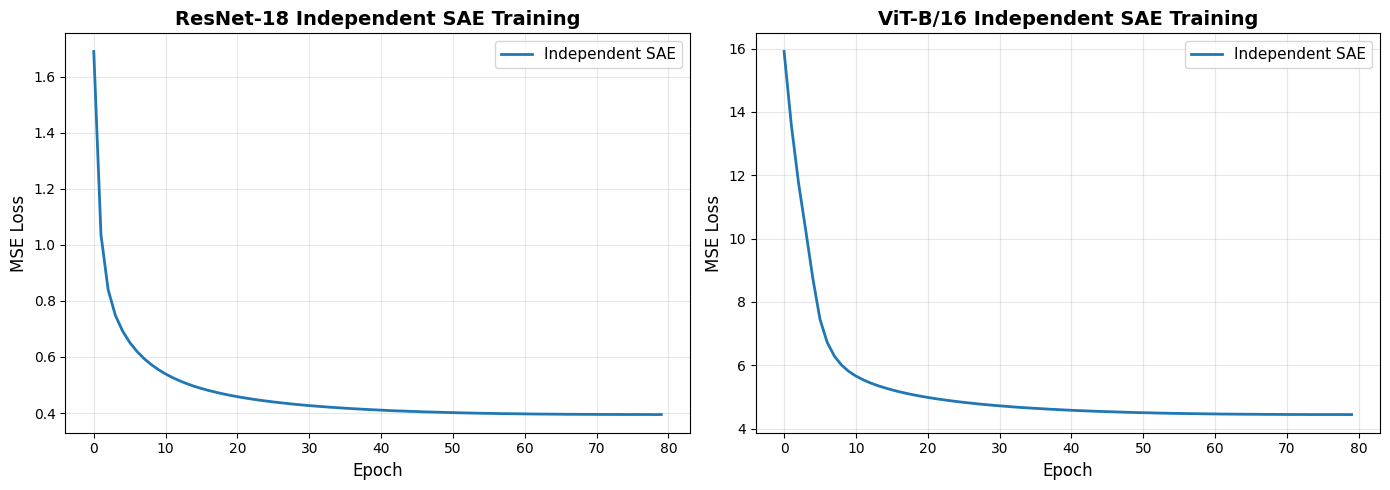

Final ResNet loss: 0.3946
Final ViT loss: 4.4465


In [37]:
# Plot training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ResNet comparison
axes[0].plot(losses_resnet, label='Independent SAE', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('ResNet-18 Independent SAE Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# ViT comparison
axes[1].plot(losses_vit, label='Independent SAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MSE Loss', fontsize=12)
axes[1].set_title('ViT-B/16 Independent SAE Training', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/independent_sae_training.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final ResNet loss: {losses_resnet[-1]:.4f}")
print(f"Final ViT loss: {losses_vit[-1]:.4f}")

### 3.4.2: Compute Alignment Tax (R² Comparison)

In [38]:
# Load USAE checkpoint
print("Loading USAE checkpoint...")
# USAE is stored as a dict of SAEs, not a single object
saes_usae = {}
for model_name in ['ResNet', 'ViT']:
    checkpoint_path = f'./checkpoints/usae_{model_name}_final.pth'
    checkpoint = torch.load(checkpoint_path)
    saes_usae[model_name] = TopKSAE(
        input_shape=512 if model_name == 'ResNet' else 768,
        n_components=16384,
        device='cuda',
        encoder_module='mlp_bn_1',
        dictionary_initializer=None,
        data_initializer=None,
        dictionary_normalization='l2',
        top_k=32
    )
    saes_usae[model_name].load_state_dict(checkpoint['model_state_dict'])
    saes_usae[model_name].eval()
    print(f"  ✓ Loaded {model_name} SAE")

print("USAE loaded successfully!")

Loading USAE checkpoint...
-----HERE-----
  ✓ Loaded ResNet SAE
-----HERE-----
  ✓ Loaded ViT SAE
USAE loaded successfully!


In [40]:
# Compute R² for Independent SAEs
print("\n=== Computing R² Scores ===")

def compute_r2_independent(sae, activations, model_name):
    sae.eval()
    batch_size = 128
    num_samples = activations.shape[0]
    
    ss_res = 0.0
    ss_tot = 0.0
    mean_act = activations.mean(dim=(0, 1)).cpu()  # [d_model] - compute once, keep on CPU
    
    with torch.no_grad():
        for batch_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(batch_idx + batch_size, num_samples)
            batch_acts = activations[batch_idx:end_idx]  # [batch, 196, d_model]
            batch_flat = batch_acts.reshape(-1, batch_acts.shape[-1]).cuda()
            
            # Get reconstruction
            output = sae(batch_flat)
            recon = output.reconstruction
            
            # Accumulate on CPU to save memory
            batch_flat_cpu = batch_flat.cpu()
            recon_cpu = recon.cpu()
            
            ss_res += torch.sum((batch_flat_cpu - recon_cpu) ** 2).item()
            ss_tot += torch.sum((batch_flat_cpu - mean_act) ** 2).item()
            
            del batch_flat, recon, batch_flat_cpu, recon_cpu
            torch.cuda.empty_cache()
    
    r2 = 1 - (ss_res / ss_tot)
    print(f"{model_name} Independent R²: {r2:.4f}")
    return r2

# Compute R² for independent SAEs
independent_sae_resnet.eval()
independent_sae_vit.eval()

r2_ind_resnet = compute_r2_independent(independent_sae_resnet, resnet_acts, "ResNet")
r2_ind_vit = compute_r2_independent(independent_sae_vit, vit_acts, "ViT")


=== Computing R² Scores ===


100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


ResNet Independent R²: 0.7138


100%|██████████| 391/391 [00:57<00:00,  6.82it/s]

ViT Independent R²: 0.7254


In [41]:
def compute_r2_usae(sae, activations, model_name):
    """Compute R² for USAE self-reconstruction."""
    sae.eval()
    batch_size = 128
    num_samples = activations.shape[0]
    
    ss_res = 0.0
    ss_tot = 0.0
    mean_act = activations.mean(dim=(0, 1)).cpu()
    
    with torch.no_grad():
        for batch_idx in tqdm(range(0, num_samples, batch_size)):
            end_idx = min(batch_idx + batch_size, num_samples)
            batch_acts = activations[batch_idx:end_idx]
            batch_flat = batch_acts.reshape(-1, batch_acts.shape[-1]).cuda()
            
            output = sae(batch_flat)
            recon = output.reconstruction
            
            batch_flat_cpu = batch_flat.cpu()
            recon_cpu = recon.cpu()
            
            ss_res += torch.sum((batch_flat_cpu - recon_cpu) ** 2).item()
            ss_tot += torch.sum((batch_flat_cpu - mean_act) ** 2).item()
            
            del batch_flat, recon, batch_flat_cpu, recon_cpu
            torch.cuda.empty_cache()
    
    r2 = 1 - (ss_res / ss_tot)
    print(f"{model_name} USAE R²: {r2:.4f}")
    return r2

r2_usae_resnet = compute_r2_usae(saes_usae['ResNet'], resnet_acts, "ResNet")
r2_usae_vit = compute_r2_usae(saes_usae['ViT'], vit_acts, "ViT")

100%|██████████| 391/391 [00:41<00:00,  9.33it/s]


ResNet USAE R²: 0.5099


100%|██████████| 391/391 [00:57<00:00,  6.75it/s]

ViT USAE R²: 0.6405


In [42]:
# Compute Alignment Tax
print("\n=== Alignment Tax Analysis ===")

alignment_tax_resnet = r2_ind_resnet - r2_usae_resnet
alignment_tax_vit = r2_ind_vit - r2_usae_vit

print(f"\nResNet-18:")
print(f"  Independent SAE R²: {r2_ind_resnet:.4f}")
print(f"  USAE R²: {r2_usae_resnet:.4f}")
print(f"  Alignment Tax: {alignment_tax_resnet:.4f} ({alignment_tax_resnet/r2_ind_resnet*100:.2f}% degradation)")

print(f"\nViT-B/16:")
print(f"  Independent SAE R²: {r2_ind_vit:.4f}")
print(f"  USAE R²: {r2_usae_vit:.4f}")
print(f"  Alignment Tax: {alignment_tax_vit:.4f} ({alignment_tax_vit/r2_ind_vit*100:.2f}% degradation)")

print(f"\nAverage Alignment Tax: {(alignment_tax_resnet + alignment_tax_vit)/2:.4f}")


=== Alignment Tax Analysis ===

ResNet-18:
  Independent SAE R²: 0.7138
  USAE R²: 0.5099
  Alignment Tax: 0.2040 (28.58% degradation)

ViT-B/16:
  Independent SAE R²: 0.7254
  USAE R²: 0.6405
  Alignment Tax: 0.0849 (11.70% degradation)

Average Alignment Tax: 0.1444


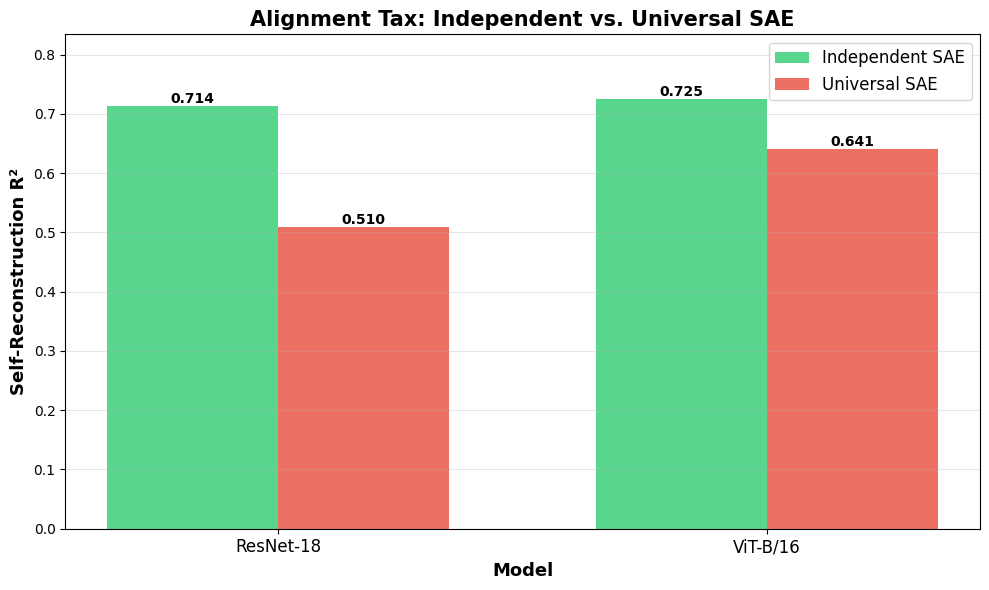

In [43]:
# Visualize R² comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = ['ResNet-18', 'ViT-B/16']
x = np.arange(len(models))
width = 0.35

independent_r2 = [r2_ind_resnet, r2_ind_vit]
usae_r2 = [r2_usae_resnet, r2_usae_vit]

bars1 = ax.bar(x - width/2, independent_r2, width, label='Independent SAE', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, usae_r2, width, label='Universal SAE', color='#e74c3c', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('Self-Reconstruction R²', fontsize=13, fontweight='bold')
ax.set_title('Alignment Tax: Independent vs. Universal SAE', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(independent_r2 + usae_r2) * 1.15])

plt.tight_layout()
plt.savefig('./results/alignment_tax_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4.3: Analyze Low-FE Features (Model-Specific)

In [44]:
# Load cached firing statistics and metrics
print("Loading cached metrics from Task 3.2...")
metrics = torch.load('./results/task_3_2_metrics.pt')
firing_entropy = metrics['fe_scores']      # [16384]
energy_scores = metrics['energy_scores']   # [16384]

print(f"Firing entropy shape: {firing_entropy.shape}")
print(f"Energy scores shape: {energy_scores.shape}")

Loading cached metrics from Task 3.2...
Firing entropy shape: torch.Size([16384])
Energy scores shape: torch.Size([16384])


In [45]:
# Identify model-specific features (Low FE)
low_fe_threshold = 0.2
low_fe_mask = firing_entropy < low_fe_threshold
low_fe_indices = torch.where(low_fe_mask)[0]

print(f"\nTotal low-FE features (FE < {low_fe_threshold}): {len(low_fe_indices)} ({len(low_fe_indices)/len(firing_entropy)*100:.1f}%)")

# Filter out dead features (never fired)
firing_stats = torch.load('./results/firing_statistics.pt')
total_fires = firing_stats['fire_counts']['ResNet'] + firing_stats['fire_counts']['ViT']  # [16384]
alive_mask = total_fires > 100

low_fe_alive = low_fe_mask & alive_mask
low_fe_alive_indices = torch.where(low_fe_alive)[0]

print(f"Low-FE features (alive, >100 fires): {len(low_fe_alive_indices)}")

# Select top-5 by energy among alive low-FE features
low_fe_energies = energy_scores[low_fe_alive_indices]
top5_energy_idx = torch.argsort(low_fe_energies, descending=True)[:5]
selected_low_fe = low_fe_alive_indices[top5_energy_idx]

print(f"\nSelected low-FE features for analysis:")
for i, feat_idx in enumerate(selected_low_fe):
    print(f"  {i+1}. Feature {feat_idx.item()}: FE={firing_entropy[feat_idx]:.3f}, Energy={energy_scores[feat_idx]:.2e}, Fires={total_fires[feat_idx]:.0f}")


Total low-FE features (FE < 0.2): 12195 (74.4%)
Low-FE features (alive, >100 fires): 3328

Selected low-FE features for analysis:
  1. Feature 2536: FE=0.023, Energy=1.14e+06, Fires=557180
  2. Feature 7999: FE=0.129, Energy=8.77e+05, Fires=425040
  3. Feature 15769: FE=0.008, Energy=8.71e+05, Fires=377394
  4. Feature 9655: FE=0.048, Energy=8.17e+05, Fires=418421
  5. Feature 12236: FE=0.079, Energy=8.07e+05, Fires=396574


In [46]:
# Determine which model each low-FE feature prefers
resnet_fires = firing_stats['fire_counts']['ResNet']
vit_fires = firing_stats['fire_counts']['ViT']

print("\nModel preference for selected low-FE features:")
for feat_idx in selected_low_fe:
    r_fires = resnet_fires[feat_idx].item()
    v_fires = vit_fires[feat_idx].item()
    total = r_fires + v_fires
    
    if r_fires > v_fires * 2:
        preference = "ResNet-specific"
    elif v_fires > r_fires * 2:
        preference = "ViT-specific"
    else:
        preference = "Weakly shared"
    
    print(f"  Feature {feat_idx.item()}: {preference}")
    print(f"    ResNet fires: {r_fires:,} ({r_fires/total*100:.1f}%)")
    print(f"    ViT fires: {v_fires:,} ({v_fires/total*100:.1f}%)")


Model preference for selected low-FE features:
  Feature 2536: ViT-specific
    ResNet fires: 1,243 (0.2%)
    ViT fires: 555,937 (99.8%)
  Feature 7999: ViT-specific
    ResNet fires: 7,579 (1.8%)
    ViT fires: 417,461 (98.2%)
  Feature 15769: ViT-specific
    ResNet fires: 262 (0.1%)
    ViT fires: 377,132 (99.9%)
  Feature 9655: ViT-specific
    ResNet fires: 2,253 (0.5%)
    ViT fires: 416,168 (99.5%)
  Feature 12236: ViT-specific
    ResNet fires: 3,876 (1.0%)
    ViT fires: 392,698 (99.0%)


In [47]:
# Visualize low-FE features using real image exemplars
print("\n=== Finding Real Image Exemplars for Low-FE Features ===")

# Load CIFAR-100 test set for visualization
transform_vis = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])
cifar100_vis = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_vis)
vis_loader = torch.utils.data.DataLoader(cifar100_vis, batch_size=128, shuffle=False, num_workers=4)

print(f"Loaded {len(cifar100_vis)} test images for visualization")


=== Finding Real Image Exemplars for Low-FE Features ===
Loaded 10000 test images for visualization


In [48]:
print("Finding top-5 exemplars for low-FE features (on-the-fly)...")

saes_usae['ResNet'].eval()
saes_usae['ViT'].eval()
resnet_model.eval()
vit_model.eval()

# Track top-5 for each feature
low_fe_exemplars = {}
for feat_idx in selected_low_fe:
    feat_idx_int = feat_idx.item()
    low_fe_exemplars[feat_idx_int] = {
        'resnet_top5': {'indices': [], 'scores': [], 'labels': []},
        'vit_top5': {'indices': [], 'scores': [], 'labels': []},
        'fe': firing_entropy[feat_idx].item(),
        'energy': energy_scores[feat_idx].item()
    }

img_offset = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(vis_loader, desc="Processing")):
        images = images.to(device)
        batch_size = images.shape[0]
        
        # ResNet
        resnet_acts = extract_resnet_features(images, resnet_model).reshape(-1, 512)
        latents_r = saes_usae['ResNet'](resnet_acts).codes.reshape(batch_size, 196, -1)
        
        # ViT
        vit_acts = extract_vit_features(images, vit_model).reshape(-1, 768)
        latents_v = saes_usae['ViT'](vit_acts).codes.reshape(batch_size, 196, -1)
        
        # Check each low-FE feature
        for feat_idx_int in low_fe_exemplars.keys():
            # Max activation per image
            max_r, _ = latents_r[:, :, feat_idx_int].max(dim=1)
            max_v, _ = latents_v[:, :, feat_idx_int].max(dim=1)
            
            # Store all for now
            for i in range(batch_size):
                low_fe_exemplars[feat_idx_int]['resnet_top5']['indices'].append(img_offset + i)
                low_fe_exemplars[feat_idx_int]['resnet_top5']['scores'].append(max_r[i].item())
                low_fe_exemplars[feat_idx_int]['resnet_top5']['labels'].append(labels[i].item())
                
                low_fe_exemplars[feat_idx_int]['vit_top5']['indices'].append(img_offset + i)
                low_fe_exemplars[feat_idx_int]['vit_top5']['scores'].append(max_v[i].item())
                low_fe_exemplars[feat_idx_int]['vit_top5']['labels'].append(labels[i].item())
        
        img_offset += batch_size
        del images, resnet_acts, vit_acts, latents_r, latents_v
        torch.cuda.empty_cache()

# Keep only top-5
for feat_idx_int in low_fe_exemplars.keys():
    # ResNet
    r_scores = low_fe_exemplars[feat_idx_int]['resnet_top5']['scores']
    top5_r = sorted(range(len(r_scores)), key=lambda i: r_scores[i], reverse=True)[:5]
    low_fe_exemplars[feat_idx_int]['resnet_indices'] = [low_fe_exemplars[feat_idx_int]['resnet_top5']['indices'][i] for i in top5_r]
    low_fe_exemplars[feat_idx_int]['resnet_scores'] = [low_fe_exemplars[feat_idx_int]['resnet_top5']['scores'][i] for i in top5_r]
    low_fe_exemplars[feat_idx_int]['resnet_labels'] = [low_fe_exemplars[feat_idx_int]['resnet_top5']['labels'][i] for i in top5_r]
    
    # ViT
    v_scores = low_fe_exemplars[feat_idx_int]['vit_top5']['scores']
    top5_v = sorted(range(len(v_scores)), key=lambda i: v_scores[i], reverse=True)[:5]
    low_fe_exemplars[feat_idx_int]['vit_indices'] = [low_fe_exemplars[feat_idx_int]['vit_top5']['indices'][i] for i in top5_v]
    low_fe_exemplars[feat_idx_int]['vit_scores'] = [low_fe_exemplars[feat_idx_int]['vit_top5']['scores'][i] for i in top5_v]
    low_fe_exemplars[feat_idx_int]['vit_labels'] = [low_fe_exemplars[feat_idx_int]['vit_top5']['labels'][i] for i in top5_v]
    
    del low_fe_exemplars[feat_idx_int]['resnet_top5']
    del low_fe_exemplars[feat_idx_int]['vit_top5']

print(f"Found top-5 exemplars for {len(low_fe_exemplars)} features")

Finding top-5 exemplars for low-FE features (on-the-fly)...


Processing: 100%|██████████| 79/79 [00:20<00:00,  3.86it/s]

Found top-5 exemplars for 5 features


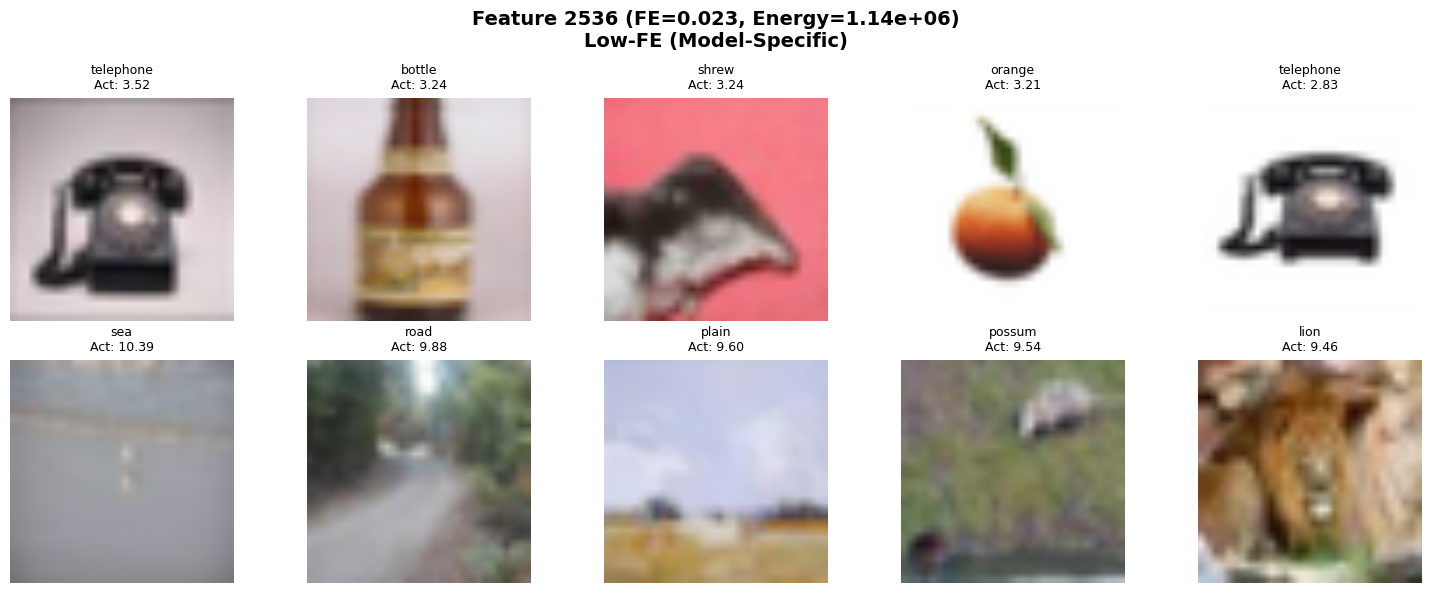


Feature 2536:
  ResNet classes: ['bottle', 'shrew', 'orange', 'telephone']
  ViT classes: ['possum', 'road', 'sea', 'lion', 'plain']
  Semantic overlap: 0/5 classes (0%)


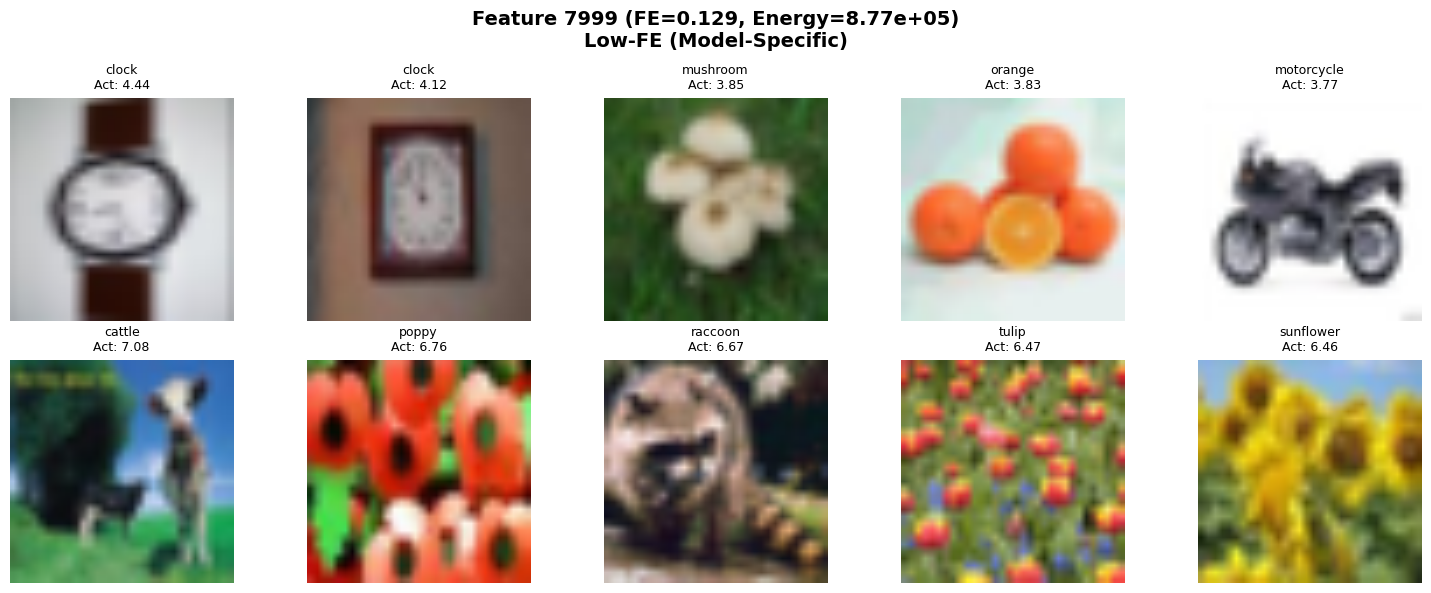


Feature 7999:
  ResNet classes: ['motorcycle', 'mushroom', 'orange', 'clock']
  ViT classes: ['raccoon', 'sunflower', 'cattle', 'tulip', 'poppy']
  Semantic overlap: 0/5 classes (0%)


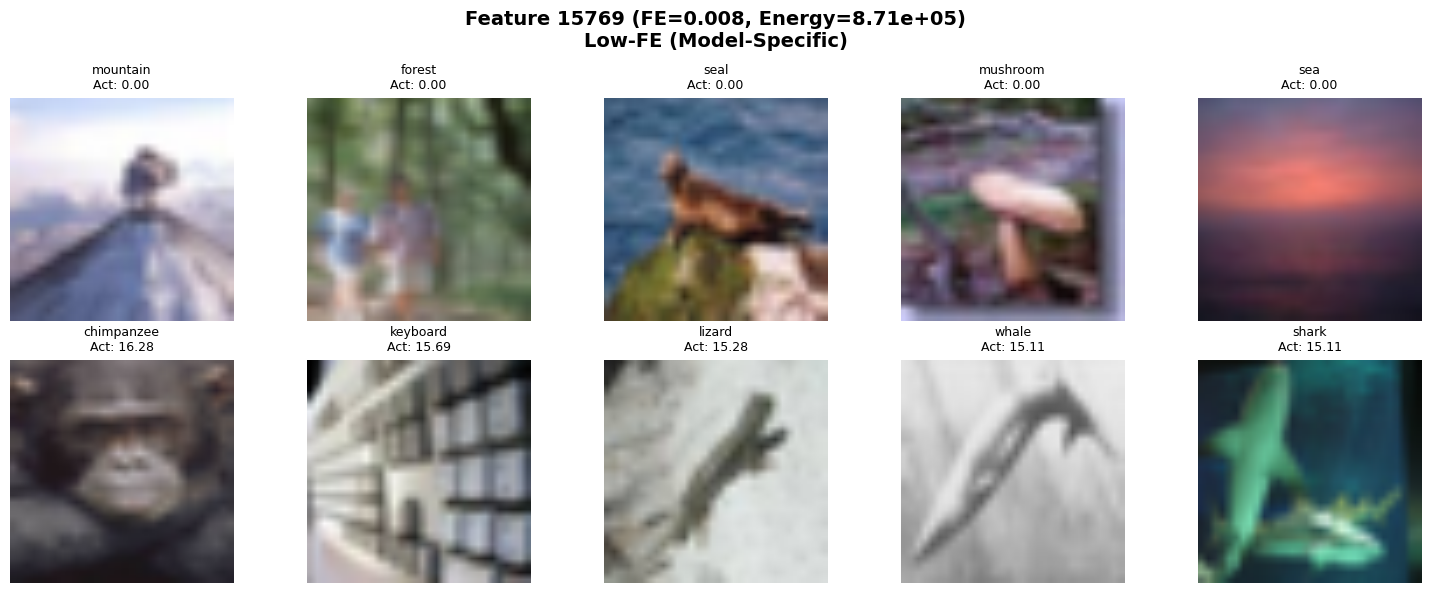


Feature 15769:
  ResNet classes: ['forest', 'sea', 'seal', 'mountain', 'mushroom']
  ViT classes: ['keyboard', 'shark', 'lizard', 'chimpanzee', 'whale']
  Semantic overlap: 0/5 classes (0%)


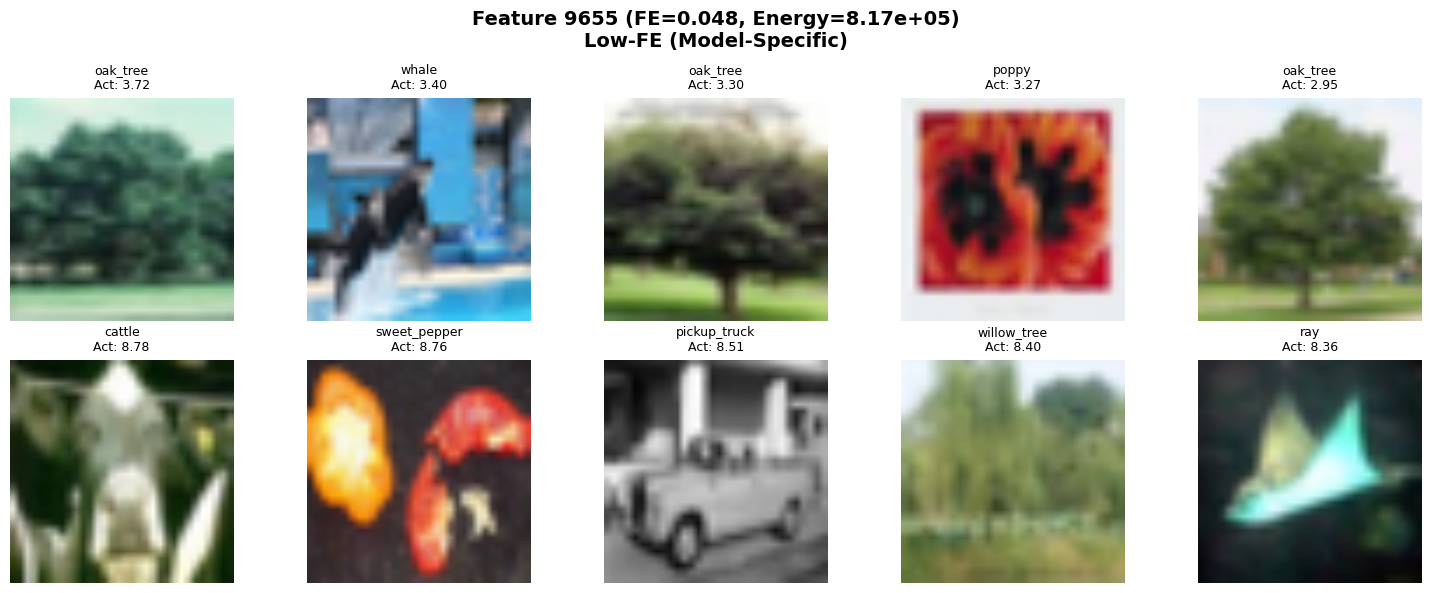


Feature 9655:
  ResNet classes: ['oak_tree', 'poppy', 'whale']
  ViT classes: ['willow_tree', 'ray', 'sweet_pepper', 'cattle', 'pickup_truck']
  Semantic overlap: 0/5 classes (0%)


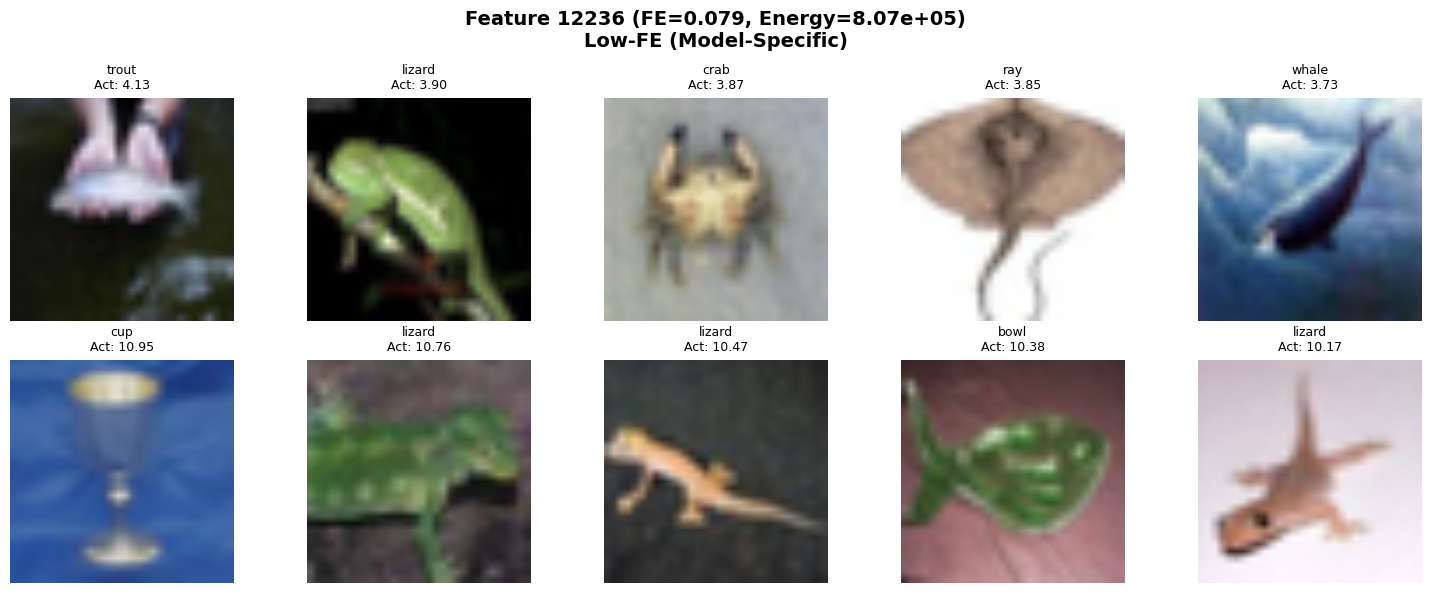


Feature 12236:
  ResNet classes: ['ray', 'lizard', 'crab', 'trout', 'whale']
  ViT classes: ['bowl', 'cup', 'lizard']
  Semantic overlap: 1/5 classes (20%)


In [49]:
# Visualize low-FE feature exemplars
os.makedirs('./results/low_fe_images', exist_ok=True)

for feat_idx, data in low_fe_exemplars.items():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Feature {feat_idx} (FE={data['fe']:.3f}, Energy={data['energy']:.2e})\nLow-FE (Model-Specific)",
                 fontsize=14, fontweight='bold')
    
    # ResNet row
    for i, (idx, score) in enumerate(zip(data['resnet_indices'], data['resnet_scores'])):
        img, label = cifar100_vis[idx]  # idx is already int, not tensor
        class_name = cifar100_vis.classes[label]
        
        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].set_title(f"{class_name}\nAct: {score:.2f}", fontsize=9)  # score is already float
        axes[0, i].axis('off')
    
    axes[0, 0].set_ylabel('ResNet-18', fontsize=12, fontweight='bold')
    
    # ViT row
    for i, (idx, score) in enumerate(zip(data['vit_indices'], data['vit_scores'])):
        img, label = cifar100_vis[idx]  # idx is already int, not tensor
        class_name = cifar100_vis.classes[label]
        
        axes[1, i].imshow(img.permute(1, 2, 0))
        axes[1, i].set_title(f"{class_name}\nAct: {score:.2f}", fontsize=9)  # score is already float
        axes[1, i].axis('off')
    
    axes[1, 0].set_ylabel('ViT-B/16', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'./results/low_fe_images/feature_{feat_idx}_low_fe.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Compute semantic overlap
    resnet_classes = set([cifar100_vis[idx][1] for idx in data['resnet_indices']])
    vit_classes = set([cifar100_vis[idx][1] for idx in data['vit_indices']])
    overlap = len(resnet_classes & vit_classes)
    
    print(f"\nFeature {feat_idx}:")
    print(f"  ResNet classes: {[cifar100_vis.classes[c] for c in resnet_classes]}")
    print(f"  ViT classes: {[cifar100_vis.classes[c] for c in vit_classes]}")
    print(f"  Semantic overlap: {overlap}/5 classes ({overlap/5*100:.0f}%)")

### 3.4.4: Save Final Results

In [50]:
# Save all Task 3.4 results
task_3_4_results = {
    # R² comparison
    'r2_independent_resnet': r2_ind_resnet,
    'r2_independent_vit': r2_ind_vit,
    'r2_usae_resnet': r2_usae_resnet,
    'r2_usae_vit': r2_usae_vit,
    'alignment_tax_resnet': alignment_tax_resnet,
    'alignment_tax_vit': alignment_tax_vit,
    
    # Low-FE analysis
    'selected_low_fe_features': selected_low_fe,
    'low_fe_exemplars': low_fe_exemplars,
    
    # Training curves
    'losses_resnet_independent': losses_resnet,
    'losses_vit_independent': losses_vit
}

torch.save(task_3_4_results, './results/task_3_4_alignment_tax.pt')
print("\n✅ Task 3.4 results saved to ./results/task_3_4_alignment_tax.pt")


✅ Task 3.4 results saved to ./results/task_3_4_alignment_tax.pt


In [51]:
# Summary statistics
print("\n" + "="*60)
print("TASK 3.4 COMPLETE - ALIGNMENT TAX ANALYSIS SUMMARY")
print("="*60)

print("\n[1] RECONSTRUCTION QUALITY (Self-Reconstruction R²):")
print(f"    ResNet-18:")
print(f"      - Independent SAE: {r2_ind_resnet:.4f}")
print(f"      - Universal SAE:   {r2_usae_resnet:.4f}")
print(f"      - Alignment Tax:   {alignment_tax_resnet:.4f} ({alignment_tax_resnet/r2_ind_resnet*100:.1f}% degradation)")
print(f"\n    ViT-B/16:")
print(f"      - Independent SAE: {r2_ind_vit:.4f}")
print(f"      - Universal SAE:   {r2_usae_vit:.4f}")
print(f"      - Alignment Tax:   {alignment_tax_vit:.4f} ({alignment_tax_vit/r2_ind_vit*100:.1f}% degradation)")

print(f"\n[2] LOW-FE FEATURES ANALYZED: {len(selected_low_fe)}")
print(f"    Total low-FE (FE<0.2): {len(low_fe_indices)} ({len(low_fe_indices)/len(firing_entropy)*100:.1f}%)")
print(f"    Selected for visualization: {len(low_fe_exemplars)}")

print("\n[4] FILES GENERATED:")
print("    - ./checkpoints/independent_saes.pt")
print("    - ./results/independent_sae_training.png")
print("    - ./results/alignment_tax_comparison.png")
print("    - ./results/low_fe_images/feature_*_low_fe.png (5 images)")
print("    - ./results/task_3_4_alignment_tax.pt")


TASK 3.4 COMPLETE - ALIGNMENT TAX ANALYSIS SUMMARY

[1] RECONSTRUCTION QUALITY (Self-Reconstruction R²):
    ResNet-18:
      - Independent SAE: 0.7138
      - Universal SAE:   0.5099
      - Alignment Tax:   0.2040 (28.6% degradation)

    ViT-B/16:
      - Independent SAE: 0.7254
      - Universal SAE:   0.6405
      - Alignment Tax:   0.0849 (11.7% degradation)

[2] LOW-FE FEATURES ANALYZED: 5
    Total low-FE (FE<0.2): 12195 (74.4%)
    Selected for visualization: 5

[4] FILES GENERATED:
    - ./checkpoints/independent_saes.pt
    - ./results/independent_sae_training.png
    - ./results/alignment_tax_comparison.png
    - ./results/low_fe_images/feature_*_low_fe.png (5 images)
    - ./results/task_3_4_alignment_tax.pt
